<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/CervejaGratis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Uma Rede neural Consegue Reproduzir uma série temporal do tipo $1/f^\beta$ atravez do seu espectro?



## For the Next


Retirar o erro do `iloc` de inserção do pandas.

Finalizar a CNN 

Colocar numero de neurônios como hyperparâmetro, e consequentemente passar isso para dentro do plot.

Colocar as `activations` functions no optuna.

Criar função `universa_loss` para o `optuna`.

Quem o droupout mata???

Colocar os progrmas em arquivos .py com os dados de .pt #lulala

# Introduction

This code is the final initial version of the attempt to make different neural network architectures able to generalize and reproduce $1/f^\beta$ noise. In the format in which this code is found, it is possible to generate data of the type $1/f^\beta$, separate them into a test and validation set, and analyze the distribution of different values ​​of $\beta$s for different generated time series structures. And test the performance of different neural network architectures.

This version is being archived on GitHub for future use. Since, we are sending it to be optimized with a hyperparameter optimizer, [optuna](https://optuna.org/).

From this code, it is possible to make scientific conclusions relevant to the study of colored noise and deep learning. However, in an attempt to achieve better accuracy in the results, we will be migrating to a version in which such a hyperparameter optimizer will be tested.

Special thanks for this version go to Doctor R Sautter, a colleague, and friend to whom he made significant contributions to the design and development of neural network architectures.

# Librarys

In [ ]:
!pip install colorednoise
!pip install optuna
import colorednoise as cn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import optuna

import seaborn as sns
from matplotlib.gridspec import GridSpec
import time
#np.random.seed(42)
#torch.manual_seed(42)
sns.set_style('darkgrid')
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 13.5 MB/s 
     |████████████████████████████████| 81 kB 11.5 MB/s 
     |████████████████████████████████| 209 kB 91.6 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 112 kB 50.9 MB/s 
     |████████████████████████████████| 50 kB 3.3 MB/s 
     |████████████████████████████████| 147 kB 62.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=afa653b4f73b107fe15c6a98725461e012bf8542f2c2368113e6bcb2f734915c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# Functions

In [136]:
class const(nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input):
        return input # simply apply already implemented SiLU

In [ ]:
def create_dataset(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  NORMALIZED DATASET BETEWENN -1 AND 1
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  dataX[3] = [3,4,5] ; dataY[3] = [6,7]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  # This function must 
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [], []
  data_test_X, data_test_Y   = [], []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    _,data_norm = norm(dataset_train[i:i + window_in + window_ou])
    data_train_X.append(data_norm[0:(window_in)])
    data_train_Y.append(data_norm[ window_in:window_in + window_ou])
    #print(len(data_train_X[i]))

    _,data_norm = norm(dataset_test[i:i + window_in + window_ou])
    data_test_X.append(data_norm[0:(window_in)])
    data_test_Y.append(data_norm[window_in:window_in + window_ou])
    #print((data_train_X).astype(float))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

def create_dataset2(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  NORMALIZED DATASET BETEWENN 0 AND 1
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  # This function must 
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [] , []
  data_test_X , data_test_Y  = [] , []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    _,data_norm = norm2(dataset_train[i:i + window_in + window_ou])
    data_train_X.append(data_norm[0:(window_in)])
    data_train_Y.append(data_norm[ window_in:window_in + window_ou])
    #print(len(data_train_X[i]))

    _,data_norm = norm2(dataset_test[i:i + window_in + window_ou])
    data_test_X.append(data_norm[0:(window_in)])
    data_test_Y.append(data_norm[window_in:window_in + window_ou])
    #print((data_train_X).astype(float))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)
def generate_data(size,win_in,win_ou,title='data.pt'):
  '''
  Create a Dataset in pytorch format and save it
  trainX[i] and trainY[i] are genereted from the same time serie 
  Normalized  between [-1,1].
  data[0] = whitenoise
  data[1] = pink noise
  data[2] = rednoise
  data[3] = Turbulence
  data[i][0] = trainX
  data[i][1] = trainY
  data[i][2] = train_testX
  data[i][3] = train_testY
  list = [0,1,2,3,4,5,6,7,8,9,10,11]
  if the window_in is equal to 3 anf window_ou equal to to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  data = [] #Empyty Vector
  betas = [0,1,2,5/3] #Values of Betas
  for i in range(len(betas)): #loop for alocate the tensot
    trainX, trainY          = dataset_test2(betas[i],size,win_in,win_ou)
    trainX_test,trainY_test = dataset_test2(betas[i],size,win_in,win_ou)
    
    data.append([trainX,trainY,trainX_test,trainY_test])
  torch.save(data, title) #Savig the file in .pt format
  return data

def skew(t):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**3,dim=1)

def kurtosis(t, fisher=True):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**4,dim=1) - fisher*3    

def param(data):
  '''
  Print the Statiscal momentun from a givin dataset
  '''
  data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    

def param_2(data):
  '''
  Print the Statiscal momentun from a givin dataset
  '''
  #data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    

def norm(data):
  '''
  Normalize the dataframe from -1 to 1
  '''
  scaler = MinMaxScaler((-1,1))
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2


def norm2(data):
  '''
  Normaliza os dados entre 0 e 1
  '''
  scaler = MinMaxScaler()
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2  

def norm4(data):
  '''
  Normaliza os dados entre 0 e 1
  but return vectors in a single shape
  '''
  #scaler = MinMaxScaler()
  scaler = MinMaxScaler((-1,1))
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1) 
  data2 = np.reshape(data1,len(data1))
  return data2  

##################
# PLOT FUNCTIONS #
##################


def plot_psd(data,label='PSD',color='k'):
  '''
  This functions will show the PSD representation for any time series
  '''
  ft = np.fft.fft(data)
  #ft = np.fft.fft(y[0,:])
  ft = np.real(ft*np.conj(ft))
  freq = np.fft.fftfreq(len(ft))
  seq = np.argsort(freq)
  a,b = np.polyfit(np.log(freq[freq>0.0]),np.log(ft[freq>0.0]),deg=1)
  text = "{} {}f + {}".format(label,np.round(a,3),np.round(b,3))
  #plota o psd
  return plt.loglog(freq[seq],ft[seq],color=color,label=text)  

def plot_test(x_,y_):
  '''
  Plot two time series in sequence
  '''
  empty = np.empty_like(x_)
  empty[:] = np.nan
  y2 = np.append(empty,y_)
  plt.plot(x_,label='Input')
  plt.plot(y2,label='Target') 


def create_dataframe(data_x,data_y,len_future=0):
    '''
     ########### CREATING DATAFRAME ###############
    #Create A inicial Dataframe with this size    
    #data_x = list(test_input_clone[0].detach().numpy().copy())
    #data_y = list(test_target_clone[0].detach().numpy().copy())
    '''
    #Is data_y larger than data_x or vice-versa?
    if len(data_y) > len(data_x):  
      for index in range(len(data_y) - len(data_x)):  data_x.append(np.nan)
    elif len(data_x) > len(data_y):
      for index in range(len(data_x) - len(data_y)):  data_y.append(np.nan)
    #Is x and y smaller then the future predicts?
    if len_future > len(data_x):
      for index in range(len_future - len(data_x)): data_x.append(np.nan)
    if len_future > len(data_y):
      for index in range(len_future - len(data_y)): data_y.append(np.nan)
    #Create a Dataframe
    df = pd.DataFrame()
    df.insert(0,'trainX',data_x)
    df.insert(1,'trainY',data_y)
    df.insert(2,'input_GNI',np.random.rand(len(data_x)))
    
    empty = np.empty_like(data_x)
    empty[:] = np.nan
    df.insert(len(df.columns),'loss_train',empty)
    df.insert(len(df.columns),'loss_valid',empty)
    df.insert(len(df.columns),'time',empty)
    return df


def append_dataframe(df,out,fut,i):
  '''
  Function for append the new coluns in the traingloop
  '''
  out = list(out)
  fut = list(fut)
  len_data = len(df)
  #is the output smaller then the df numer of lines?  
  if len(out) < len_data:  
    for index_1 in range(len_data - len(out)):    out.append(np.nan)
  #is the output smaller then the df numer of lines?
  if len(fut) < len_data:  
    for index_2 in range(len_data - len(fut)):    fut.append(np.nan)

  df.insert(len(df.columns),f'out{i+1}',out)
  df.insert(len(df.columns),f'fut{i+1}',fut)

def plot_results(x,y,z,w,shift_1=0,epoch=0):
  '''
  One single function to plot all the results
  '''
  plt.figure(figsize=(15,6))
  plt.suptitle(f'Results for Epoch {epoch+1}',  y=1.00, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)
  gs = GridSpec(1,2,width_ratios=[2,1])

  plt.subplot(gs[0,0])
  plt.title("Time Series")
  plt.xlabel("x")
  plt.ylabel("y")

  shift_2 = len(x) + shift_1
  shift_3 = len(y) + shift_2
  plt.plot(np.arange(shift_1,shift_1+len(x)), x, color='C0',      linewidth=1.0,label='Input')            
  plt.plot(np.arange(shift_2,shift_2+len(y)), y, color='C1',      label='Target')
  plt.plot(np.arange(shift_2,shift_2+len(z)), z, color = 'brown', linewidth=1.0,label='Model Output')
  plt.plot(np.arange(shift_3,shift_3+len(w)), w, color = 'green', linewidth=1.0,label='Future')
  plt.axvline(shift_3,ls='--')
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
           ncol=4, fancybox=True, shadow=True)#,prop={'size': 15}) 

  plt.subplot(gs[0,1])
  plot_psd(z,'Expected','brown')
  plot_psd(w,'Future','green')
  plot_psd(y,'Output','C1')
  plt.title('Power Spectrum Density')
  plt.xlabel("f (Frequency)")
  plt.ylabel("Energy (PSD)")
  plt.tight_layout()
  for k in range(n_cut): plt.axvline(x=(len(x)**(-(k+1)/n_cut)),color='r',ls='--')
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
           ncol=1, fancybox=True, shadow=True)#,prop={'size': 15}) 

  #plt.savefig("predict%d.png"%i, dpi=200)
  plt.show()
  plt.close()


def plot_loss(train,valid,title='Loss Metrics'):
  '''
  Plot Loss metrics
  '''
  plt.figure(figsize=(15,6))
  plt.title(title)
  plt.plot(train,label='Train')
  plt.plot(valid,label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()


def dt(t0,t1):
  '''
  Print Time Interval
  '''
  dt = t1-t0
  if dt < 60:           dtf = str(round(dt,3))+' s'
  elif 3600 > dt > 60:  dtf = str(round(dt/60,3))+' min'
  elif dt > 3600:       dtf = str(round(dt/3600,3))+' hours'
  return dtf      

In [ ]:
## Functions for Data Analize
def dataset_test(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  Create a data 1 sets for teste the spectra time series
  Here the data_set will be splited like in create_dataset but without test data
  All the data will be splited in two type of series.
  '''
  data_train_X, data_train_Y = [], []
  for i in range(0,len(dataset)-window_in-window_ou+1,strid):
    data_train_X.append(norm4(dataset[i:(i+window_in)]))
    data_train_Y.append(norm4(dataset[i + window_in:i + window_in + window_ou]))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

#Data Set 03 - TrainX and TrainY from a single Series

def dataset_test2(beta,n_series, len_trainX=10,len_trainY=10,isTensor=True):
  '''
  We create a time serie and split it in trainX and trainY
  '''
  data_train_X, data_train_Y = [], []
  for i in range(n_series):
    dataset = norm4(cn.powerlaw_psd_gaussian(beta, len_trainX+len_trainY))
    data_train_X.append(dataset[:len_trainX])
    data_train_Y.append(dataset[len_trainX:])
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)    


## Δβ - Diferent Index


A biblioteca pytorch possui as funções de transformada rápida de fourier (fft),respectivo conjunto de frequência (fftfreq) e logarítmo implementada já a nível vetorizado.

No entanto, foi necessário implementar manualmente o ajuste linear para medir o beta, uma boa referência (com o método dos minimos quadrados) é:

http://195.134.76.37/applets/AppletPoly/Appl_Poly2.html

In [ ]:
# class DBeta(nn.Module):
#   def __init__(self):
#     super(DBeta, self).__init__();

#   def beta(self,vet):
#     ft = torch.fft.fft(vet,dim =1)
#     ft = ft*torch.conj(ft)
#     psd = torch.real(ft)
#     freq = torch.fft.fftfreq(vet.size(dim=1))
#     freq = freq.repeat(psd.size(dim=0),1)

#     # remove frequencias negativas e zero
#     freq = freq[:,1:vet.size(dim=1)//2]
#     psd = psd[:,1:vet.size(dim=1)//2]
#     #passa para escala log
#     freq = torch.log(freq)
#     psd = torch.log(psd)

#     # calcula o angulo do ajuste linear
#     b = (psd.size(dim=1)*torch.sum(psd*freq,dim=1)-torch.sum(psd,dim=1)*torch.sum(freq,dim=1))/(psd.size(dim=1)*torch.sum(freq**2,dim=1) - (torch.sum(freq,dim=1)**2) )
#     return b
    
#   def forward(self, predictions, target):
#     square_difference = torch.square(self.beta(predictions) - self.beta(target))
#     return torch.mean(square_difference)

#   def __call__(self, predictions, target):
#     square_difference = torch.square(self.beta(predictions) - self.beta(target))
#     return torch.mean(square_difference)

## Δβλ - Separete the PSD in `n_cut` sizes
This function will return the value of the $\beta$ index from a linearized time series or, the values if de `n_cut` is larger then $1$.

In [ ]:
class DBeta(nn.Module):
  def __init__(self,n_cut=1, low_freq_cut=0 ,high_freq_cut=0 ):
    super(DBeta, self).__init__();
    '''
    >>>>> DELTA BETA funcion <<<<<<
    This function will calculate the power law index beta in the power spectrum
    space for a given time series and  split it from a frequency space in n_cut times.
    You can also select what kind of part of the frequency could NOT been calulated
    Ignoring low and high frequncys.

    n_cut        - is the number of cuted betas
    low_freq_cut - Is the ignored first betas
    high_freq_cut - its the ignored last betas
    '''         
    self.n_cut = n_cut                                    #Save n_cut numbers in the object
    self.high_freq_cut = high_freq_cut                    #How many parts from higth frequency will be ignored
    self.low_freq_cut = low_freq_cut                      #How many parts from low frequency will be ignored
  def psd(self,vet):                
      ft = torch.fft.fft(vet,dim =1)                      #ft will computes the one dimensional discrete Fourier transform of input.
      ft = ft*torch.conj(ft)                              #Extract the conjugated complex from the tranformation
      psd = torch.real(ft)                                #Take only the real values from the transformation
      freq = torch.fft.fftfreq(vet.size(dim=1))           #freq will computes the discrete Fourier Transform sample frequencies for a signal of size n 
      freq = freq.repeat(psd.size(dim=0),1)               #?????
      freq = freq[:,1:vet.size(dim=1)//2]                 #?????
      psd = psd[:,1:vet.size(dim=1)//2]                   #?????
      return psd, freq         
           
  def beta(self,vet):                                     #n_cut number of cut for the series
    n_cut = self.n_cut                                    
    low_freq_cut = self.low_freq_cut                      #Setting the low freqs
    high_freq_cut = self.high_freq_cut                    #Setting hig_freq_cut 
    psd,freq = self.psd(vet)                              #generating the PSD and FREQ returned by the psd function
    beta= torch.zeros(vet.size(0), n_cut)                 #Alocating a lot of zeros in the beta vector wwith vec size
    for i in range(low_freq_cut,n_cut-high_freq_cut):   
      for j in range(vet.size(0)): 
        int_min,int_max = len(vet)**(-(i+1)/n_cut),len(vet)**(-(i)/n_cut)
        p = psd[j,:]
        f = freq[j,:]
        p = p[(f>int_min) & (f<int_max)]
        f = f[(f>int_min) & (f<int_max)]
        p = torch.log(p)
        f = torch.log(f)
        
        b = (p.size(0)*torch.sum(p*f)-torch.sum(p)*torch.sum(f))/(p.size(0)*torch.sum(f**2) - (torch.sum(f)**2) )
        beta[j,i] = b
    return beta
    
  def forward(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.mean(square_difference)

  def __call__(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.mean(square_difference)

# Data 
Here we will study the structure of differents data analizes to discute the $1/f$ aplications

## Data 1: Combined $w_1 \sin(x) + w_2 \sin(x)$

Combined $w_1 \sin(x+\theta_1) + w_2 \sin(x+\theta_2) + Noise()$

https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

In [ ]:
# def generate_time_series(batch_size, n_steps,w1=0.5,w2=0,w3=0,w4=0,f1=1000,f2=1000,f3=1000,var_freq=True):
#     #offsets1, offsets2 = np.random.rand(2, batch_size, 1)
#     if var_freq == True:
#       freq1, freq2 = np.random.rand(2, batch_size, 1)
#     else:
#       freq1, freq2 = np.empty((batch_size,n_steps), np.float32), np.empty((batch_size,n_steps), np.float32), 
#       freq1[:], freq2[:] = 0.5,0.5
#     time = np.linspace(0, 1, n_steps)
#     series =  w1 * np.sin((time ) * (freq1 * f1))  #   wave 1
#     series += w2 * np.sin((time ) * (freq1 * f2)) # + wave 2
#     series += w3 * np.sin((time ) * (freq1 * f3)) # + wave 2
#     series += w4 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
#     return series#[..., np.newaxis].astype(np.float32)

# N = 1 # number of time series
# L = 2**20 # length of each sample (number of values for each sine wave)

# y1 = generate_time_series(batch_size=N,
#                          n_steps = L,
#                          w1= 1,   w2=0,     w3=0.00,   w4 = 0.0,
#                          f1= 50000,f2 = 3000,f3 = 1000, 
#                          var_freq=False)

# y2 = generate_time_series(batch_size=N,
#                          n_steps = L,
#                          w1= 0,   w2=2,     w3=0.00,   w4 = 0.0,
#                          f1= 50000,f2 = 50000//4,f3 = 1000, 
#                          var_freq=False)
# y3 = y2[0]+y1[0]
# #!wget "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
# # df_airlines = pd.read_csv('airline-passengers.csv')
# # airlines = df_airlines.iloc[:,1].values


# plt.figure(figsize=(8,10))
# font=14
# def plot_sin(data,color,title):
#   plt.plot(data,color=color)
#   plt.xlim(0,2*1024)
#   plt.ylim(min(y3)-0.5,max(y3)+0.5)
#   plt.xlabel('Time (s)',fontsize=font)
#   plt.xticks(fontsize=font)
#   plt.yticks(fontsize=font)
#   plt.ylabel('Amplitude',fontsize= font)
#   plt.title(title,fontsize= font)

# def plot_sinPSD(data,title):
#   plot_psd(data)
#   plt.xlim(1e-4,0)
#   plt.ylim(0,1e13)
#   plt.xlabel('Frequency (Hz)',fontsize=font)
#   plt.ylabel('PSD',fontsize= font)
#   plt.yticks(fontsize=font)
#   plt.title(title,fontsize= font)


# plt.subplot(3,2,1)
# plot_sin(y1[0],'C0','(a)')


# plt.subplot(3,2,2)
# plot_sinPSD(y1[0],'(b)')

# plt.subplot(3,2,3)
# plot_sin(y2[0],'C1','(c)')

# plt.subplot(3,2,4)
# plot_sinPSD(y2[0],'(d)')


# plt.subplot(3,2,5)
# plot_sin(y3,'C2','(e)')

# plt.subplot(3,2,6)
# plot_sinPSD(y3,'(f)')

# # plt.subplot(4,2,7)
# # plt.plot(dataset,color='C3')
# # plt.xlabel('Time',fontsize=font)
# # plt.ylabel('Nº of Passengers',fontsize=font)
# # plt.title('(e)',fontsize=font)

# # plt.subplot(4,2,8)
# # plot_psd(dataset)
# # #plt.xlim(1e-4,0)
# # #plt.ylim(0,1e13)
# # plt.xlabel('Frequency (Hz)',fontsize=font)
# # plt.ylabel('PSD',fontsize= font)
# # plt.yticks(fontsize=font)
# # plt.title('(f)',fontsize= font)


# #plot_sinPSD(dataset,'(f)')

# plt.tight_layout()

# plt.savefig('PSD_exemple.pdf',dpi=200,bbox_inches='tight')


## Data 2: Colored Noise

In [ ]:
# samples = 2**20 #Numbert os points

# wn = cn.powerlaw_psd_gaussian(0, samples)   #White noise generation
# pn = cn.powerlaw_psd_gaussian(1, samples)   #Pink Noise generation
# tn = cn.powerlaw_psd_gaussian(5/3, samples) #Turbulence data generation
# rn = cn.powerlaw_psd_gaussian(2, samples)   #Red Noise gereneration
 
# #Normalizing to -1 to 1 data
# wn1,wn2 = norm(wn)
# pn1,pn2 = norm(pn)
# rn1,rn2 = norm(rn) 
# tn1, tn2 = norm(tn) 

In [ ]:
# plt.figure(figsize=(8,10))
# font=13
# plt.subplot(4,2,1)
# plt.plot(wn2,color='black',alpha=1,linewidth=0.2)
# plt.title('(a)',fontsize=font)
# plt.xlabel('Time Steps',fontsize=font)
# plt.yticks(fontsize=font)

# plt.subplot(4,2,2)
# plot_psd(wn2)
# plt.ylim(1e-6,1e12)
# plt.yticks(fontsize=font)
# plt.legend()
# plt.xlabel('Frequency (Hz)',fontsize=font)
# plt.title('(b)',fontsize=font)

# plt.subplot(4,2,3)
# plt.plot(pn2,color='magenta',alpha=1,linewidth=0.3)
# plt.yticks(fontsize=font)
# plt.title('(c)',fontsize=font)
# plt.xlabel('Time Steps',fontsize=font)

# plt.subplot(4,2,4)
# plot_psd(pn2,color='magenta')
# plt.ylim(1e-6,1e12)
# plt.xlabel('Frequency (Hz)',fontsize=font)
# plt.yticks(fontsize=font)
# plt.legend()
# plt.title('(d)',fontsize=font)

# plt.subplot(4,2,5)
# plt.plot(tn2,color='blue',linewidth=0.3)
# plt.yticks(fontsize=font)
# plt.title('(e)',fontsize=font)
# plt.xlabel('Time Steps',fontsize=font)

# plt.subplot(4,2,6)
# plot_psd(tn2,color='blue')
# plt.ylim(1e-6,1e12)
# plt.xlabel('Frequency (Hz)',fontsize=font)
# plt.yticks(fontsize=font)
# plt.title('(f)',fontsize=font)
# plt.legend()

# plt.subplot(4,2,7)
# plt.plot(rn2,color='red',linewidth=0.3)
# plt.yticks(fontsize=font)
# plt.title('(g)',fontsize=font)
# plt.xlabel('Time Steps',fontsize=font)

# plt.subplot(4,2,8)
# plot_psd(rn2,color='red')
# plt.ylim(1e-6,1e12)
# plt.xlabel('Frequency (Hz)',fontsize=font)
# plt.yticks(fontsize=font)
# plt.title('(h)',fontsize=font)
# plt.legend()

# plt.tight_layout()
# #plt.savefig('PSD_all_data.pdf',dpi=200,bbox_inches='tight')


# plt.show()

# Creating `trainX` and `trainY`

In [ ]:
# ### ⚠️⚠️⚠️⚠️⚠️ COMENTEND ⚠️⚠️⚠️⚠️⚠️⚠️ ###
# #This cell will creat and save large among of data
# #Generate and Save All data
# win_in = [1024,1024,1024,2048,2048,2048,4096,4096,4096]
# win_ou = [1024,2048,4096,1024,2048,4096,1024,2048,4096]
# n_series = 2**13

# for i in range(len(win_in)):
#   data = generate_data(n_series,win_in[i],win_ou[i],
#                      title=f'data_X{win_in[i]}_Y{win_ou[i]}_n{n_series}.pt')
# # Zip File 📦
# !zip -r /content/All_Files.zip /content  

# ##### 🆙🆙🆙🆙🆙🆙 LOAD THE DATA 🆙🆙🆙🆙🆙🆙🆙 #####
# win_in = 1024
# win_ou = 2048
# n_series = 2**13
# data1 = torch.load(f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
# trainX, trainY, trainX_test,trainY_test = data1[2][0],data1[2][1],data1[2][2],data1[2][3]

In [ ]:
win_in = 1024
win_ou = 1024*2
#jump = 512*16*4
n_series = 8

#dataset = rn
#trainX, trainY, trainX_test,trainY_test = create_dataset(dataset,win_in,win_ou,jump,isTensor=True)
data = generate_data(n_series,win_in,win_ou,
                     title=f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
beta = 2
trainX, trainY, trainX_test,trainY_test = data[beta][0],data[beta][1],data[beta][2],data[beta][3]

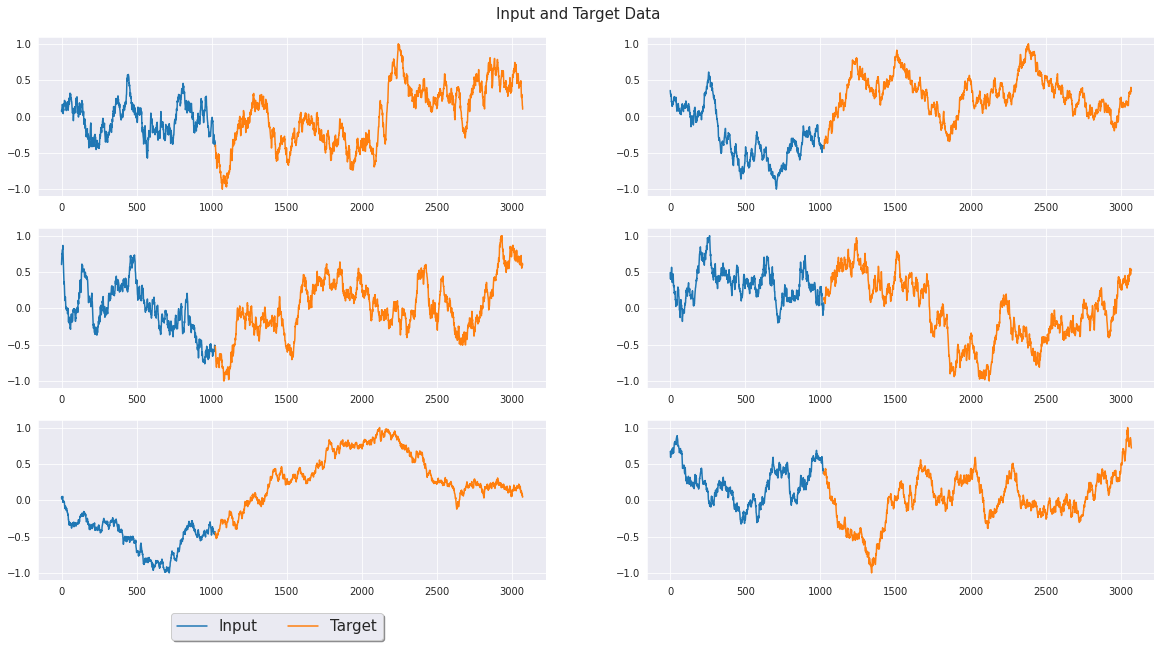

In [ ]:
#Ploting a Sequence of Series for the dataframe
plt.figure(figsize=(20,10))
plt.suptitle('Input and Target Data',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
for k in range(6):
  plt.subplot(3,2,k+1)
  plot_test(trainX_test[k],trainY_test[k])
plt.legend(loc='lower center', bbox_to_anchor=(-0.73, -0.42),
           ncol=4, fancybox=True, shadow=True,prop={'size': 15}) 
plt.show()

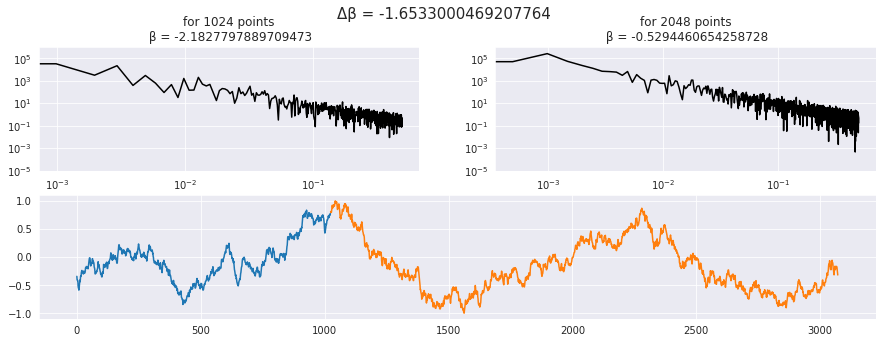

In [ ]:
#Ploting train and target data with his power spectruns
k = 0
l = DBeta(2)
plt.figure(figsize=(15,5))
plt.suptitle(f'Δβ = {round((l.beta(torch.Tensor(trainX))[k].detach().numpy()[0] - l.beta(torch.Tensor(trainY))[k].detach().numpy()[0]),4)}',  y=0.95, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
plt.subplot(2,2,1)
plot_psd(trainX[k])
plt.ylim(1e-5,1e6)
plt.title(f'for {len(trainX[k])} points\n β = {l.beta(torch.Tensor(trainX))[k].detach().numpy()[0]}')
plt.subplot(2,2,2)
plt.title(f'for {len(trainY[k])} points\n β = {l.beta(torch.Tensor(trainY))[k].detach().numpy()[0]}')
plot_psd(trainY[k])
plt.ylim(1e-5,1e6)
plt.subplot(2,2,(3,4))
plot_test(trainX[k],trainY[k])
#plt.text(1, 1, r'$\mathcal{A}\mathrm{sin}(2 \omega t)$')

# Data Analysis

In [ ]:
# win_in = 128
# win_ou = 2048*2
# jump   = 512

# #Data Set 01 - Recorted dataset
# trainX_wn_01, trainY_wn_01 = dataset_test(wn,win_in,win_ou,jump,isTensor=True)
# trainX_pn_01, trainY_pn_01 = dataset_test(pn,win_in,win_ou,jump,isTensor=True)
# trainX_rn_01, trainY_rn_01 = dataset_test(rn,win_in,win_ou,jump,isTensor=True)

# #Data Set 02 - Generated All Single Series

# trainX_wn_02,trainX_pn_02,trainX_rn_02 = [],[],[]
# trainY_wn_02,trainY_pn_02,trainY_rn_02 = [],[],[]
# for i in range(len(trainX_wn_01)):
#   trainX_wn_02.append(norm4(cn.powerlaw_psd_gaussian(0, win_in)))
#   trainY_wn_02.append(norm4(cn.powerlaw_psd_gaussian(0, win_ou)))
#   trainX_pn_02.append(norm4(cn.powerlaw_psd_gaussian(1, win_in)))
#   trainY_pn_02.append(norm4(cn.powerlaw_psd_gaussian(1, win_ou)))
#   trainX_rn_02.append(norm4(cn.powerlaw_psd_gaussian(2, win_in)))
#   trainY_rn_02.append(norm4(cn.powerlaw_psd_gaussian(2, win_ou)))

# trainX_wn_02, trainY_wn_02= torch.tensor(trainX_wn_02), torch.tensor(trainY_wn_02)
# trainX_pn_02, trainY_pn_02= torch.tensor(trainX_pn_02), torch.tensor(trainY_pn_02)
# trainX_rn_02, trainY_rn_02= torch.tensor(trainX_rn_02), torch.tensor(trainY_rn_02)

# #Data Set 03 - TrainX and TrainY from a single Series
# trainX_wn_03, trainY_wn_03 = dataset_test2(0,len(trainX_wn_01),win_in,win_ou)
# trainX_pn_03, trainY_pn_03 = dataset_test2(1,len(trainX_wn_01),win_in,win_ou)
# trainX_rn_03, trainY_rn_03 = dataset_test2(2,len(trainX_wn_01),win_in,win_ou)

In [ ]:
# plt.figure(figsize=(20,10))
# plt.suptitle('Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
# k=0
# plt.subplot(3,3,1)
# plt.ylabel(f'Splited from 2^{int(np.log2(len(wn)))} points')
# #plt.title('White Noise')
# plot_test(trainX_wn_01[k],trainY_wn_01[k])
# plt.subplot(3,3,2)
# #plt.title('Pink Noise')
# plot_test(trainX_pn_01[k],trainY_pn_01[k])
# plt.subplot(3,3,3)
# #plt.title('Red Noise')
# plot_test(trainX_rn_01[k],trainY_rn_01[k])

# plt.subplot(3,3,4)
# plt.ylabel(f'Created separately')
# plot_test(trainX_wn_02[k],trainY_wn_02[k])
# plt.subplot(3,3,5)
# plot_test(trainX_pn_02[k],trainY_pn_02[k])
# plt.subplot(3,3,6)
# plot_test(trainX_rn_02[k],trainY_rn_02[k])    

# plt.subplot(3,3,7)
# plt.ylabel(f'Splited from 1 singel serie')
# plot_test(trainX_wn_03[k],trainY_wn_03[k])
# plt.subplot(3,3,8)
# plot_test(trainX_pn_03[k],trainY_pn_03[k])
# plt.subplot(3,3,9)
# plot_test(trainX_rn_03[k],trainY_rn_03[k])

# plt.legend(loc='lower center', bbox_to_anchor=(-0.73, -0.42),
#            ncol=4, fancybox=True, shadow=True,prop={'size': 15}) 
# plt.show()

In [ ]:
# #l = DBeta(n_cut)

# bet_index = 2
# n_cut = 3
# n_rowns = 4
# #vets = [trainX_wn_01,trainX_wn_02,trainX_wn_03]
# #vets = [trainX_pn_01,trainX_pn_02,trainX_pn_03]
# vets = [trainX_rn_01,trainX_rn_02,trainX_rn_03]


# def plot_ncut_beta(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi1  = 1,title=None): 
#   plt.subplot(n_rowns,c_colum,possi1)
#   for i in range(0,n_cut): 
#     l = DBeta(n_cut)#(i+1)#??????????  
#     sns.distplot(-l.beta(vet)[:,i],label=f'Cut {i+1}')
#   plt.axvline(bet_index,color = 'r', linestyle='--')
#   #plt.title(title)
#   plt.legend()

# def plot_cuted_psd(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi2  = 1,title=None):
#   plt.subplot(n_rowns,c_colum,possi2)
#   plot_psd(vet[0])
#   for i in range(n_cut):  
#     plt.axvline(x=(len(vet[0])**(-(i+1)/n_cut)),color='r',ls='--')


# plt.figure(figsize=(20,16))
# plt.suptitle('β Distribuition  fot Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
# for i in range(1,n_cut+1):
#   plot_cuted_psd(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi2  = i        ,title=f'{1}º cut')
#   plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi1  = (n_cut+i),title=f'{i}º cut')
#   plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[1], n_rowns = n_rowns,c_colum = n_cut,possi1  = (2*n_cut+i),title=f'{i}º cut')
#   plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[2], n_rowns = n_rowns,c_colum = n_cut,possi1  = (3*n_cut+i),title=f'{i}º cut')

In [ ]:
# print('kurtosis',kurtosis(torch.tensor([wn2])))
# print('mean',torch.mean(torch.tensor([wn2])))
# print('skew',skew(torch.tensor([wn2])))
# print('std',torch.std(torch.tensor([wn2])))

## Plot on Violin


In [ ]:
# #Ploting Paramenters

# #df = pd.DataFrame({'White Noise':wn_Y,'Pink Noise':pn_Y,'Red Noise':rn_Y})
# n_cut = 6
# l = DBeta(n_cut)
# #data = vets[0]
# bet_index = 2
# n_rowns = 4
# #vets = [trainX_rn_01,trainX_rn_02,trainX_rn_03]
# vets = [trainX,trainY]
# data_name = "Sin"

# def beta_df(data,data_name,n_cut):
#   cuted_beta = [] #empty vector
#   for i in range(n_cut): cuted_beta.append(-l.beta(data)[:,i]) #Alocating betas from the functions
#   sum = torch.cat(cuted_beta).detach().numpy() #concatoneting all data in ine single numpy vector
#   _df = pd.DataFrame() #Creating a dataframe
#   _df.insert(0,data_name,sum) #Inserting sum on data frame
#   _ds = [] #creating a vector for cut type
#   for i in range(len(cuted_beta)): 
#     for j in range(cuted_beta[i].size(0)): _ds.append(f'Cut {i}')
#   _df.insert(1,'ds',_ds)
#   return _df


# def plot_ncut_beta_violin(bet = 0,n_cut = 4,vet = vets[0],n_rowns = 1,c_colum = 1,possi1  = 1,title=None): 
#   plt.subplot(n_rowns,c_colum,possi1)
#   for i in range(0,n_cut): 
#     l = DBeta(n_cut)#(i+1)#??????????  
#     sns.violinplot(x='ds',y=data_name,data=beta_df(vet,data_name,n_cut))
#   #plt.title(title)
#   #plt.legend()

# def plot_cuted_psd(bet = 0,n_cut = 4,vet = vets[0],n_rowns = 1,c_colum = 1,possi2  = 1,title=None):
#   plt.subplot(n_rowns,c_colum,possi2)
#   plot_psd(vet[0])
#   for i in range(n_cut):  
#     plt.axvline(x=(len(vet[0])**(-(i+1)/n_cut)),color='r',ls='--')

# plt.figure(figsize=(20,16))
# plt.suptitle('β Distribuition  fot Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
# for i in range(1,n_cut+1):
#   plot_cuted_psd(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi2  = i        ,title=f'{1}º cut')
#   plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi1  = (n_cut+i),title=f'{i}º cut')
#   plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[1], n_rowns = n_rowns,c_colum = n_cut,possi1  = (2*n_cut+i),title=f'{i}º cut')
#   #plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[2], n_rowns = n_rowns,c_colum = n_cut,possi1  = (3*n_cut+i),title=f'{i}º cut')

In [ ]:
# #Ploting Paramenters

# #df = pd.DataFrame({'White Noise':wn_Y,'Pink Noise':pn_Y,'Red Noise':rn_Y})
# n_cut = 3
# l = DBeta(n_cut)
# data = vets[0]
# bet_index = 2
# n_rowns = 4
# vets = [trainY_rn_01,trainY_rn_02,trainY_rn_03]
# data_name = "Red Noise"

# def beta_df(data,data_name,n_cut):
#   cuted_beta = [] #empty vector
#   for i in range(n_cut): cuted_beta.append(-l.beta(data)[:,i]) #Alocating betas from the functions
#   sum = torch.cat(cuted_beta).detach().numpy() #concatoneting all data in ine single numpy vector
#   _df = pd.DataFrame() #Creating a dataframe
#   _df.insert(0,data_name,sum) #Inserting sum on data frame
#   _ds = [] #creating a vector for cut type
#   for i in range(len(cuted_beta)): 
#     for j in range(cuted_beta[i].size(0)): _ds.append(f'Cut {i}')
#   _df.insert(1,'ds',_ds)
#   return _df


# def plot_ncut_beta_violin(bet = 0,n_cut = 4,vet = trainY_wn_01,n_rowns = 1,c_colum = 1,possi1  = 1,title=None): 
#   plt.subplot(n_rowns,c_colum,possi1)
#   for i in range(0,n_cut): 
#     l = DBeta(n_cut)#(i+1)#??????????  
#     sns.violinplot(x='ds',y=data_name,data=beta_df(vet,data_name,n_cut))
#   #plt.title(title)
#   #plt.legend()

# def plot_cuted_psd(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi2  = 1,title=None):
#   plt.subplot(n_rowns,c_colum,possi2)
#   plot_psd(vet[0])
#   for i in range(n_cut):  
#     plt.axvline(x=(len(vet[0])**(-(i+1)/n_cut)),color='r',ls='--')

# plt.figure(figsize=(20,16))
# plt.suptitle('β Distribuition  fot Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
# for i in range(1,n_cut+1):
#   plot_cuted_psd(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi2  = i        ,title=f'{1}º cut')
#   plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi1  = (n_cut+i),title=f'{i}º cut')
#   plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[1], n_rowns = n_rowns,c_colum = n_cut,possi1  = (2*n_cut+i),title=f'{i}º cut')
#   plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[2], n_rowns = n_rowns,c_colum = n_cut,possi1  = (3*n_cut+i),title=f'{i}º cut')

# Models

A ideia dessa rede é evitar a dissonância informacional. A rede guarda internamente a memória de curto prazo, ao informar novamente a rede sobre o estado de curto prazo, poderemos estar reintroduzindo informação que já foi filtrada/descartada. Esta reintrodução de dado espúrio estamos chamando de dissonância informacional.

## [10 Hyperparameters to keep an eye on for your LSTM model — and other tips](https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4)

1. ✅NUMBER OF NODES AND HIDDEN LAYERS 

2. ✅ NUMBER OF UNITS IN A DENSE LAYER 

3. ✅ DROPOUT

4. WEIGHT INITIALIZATION

5. DECAY RATE

6. ✅ ACTIVATION FUNCTION

7. ✅ LEARNING RATE

8. MOMENTUM

9. ✅ NUMBER OF EPOCHS

10. BATCH SIZE

EXTRA 

1. OPTIMIZATION SETUP

2. ✅ NETWORK STRUCTURE (RNN, LSTM, GRU)

3. ✅ MODEL PARAMETERS

## Training Loop

In [79]:
def training_loop(n_epochs,     #Number of epochs
                  model,        #Model used for traingin 
                  loss_fn,      #Loss Functions 
                  train_input,  #Train data flow in the model traing
                  train_target, #Target data for traing
                  test_input,   #Data who will not be user for update weigths
                  test_target,  # "    "   "   "
                  optimiser,    #Optimizer criteria used in the model
                  lr  = 0.01,   # Learning Rate 
                  future=0,     # How many points in the future the model will generate
                  n_cut=1,      # Number of division of frequency in frequenct space
                  file_name='result.plk', #data Outputa name
                  plot_results_during_traing=True,
                  save_results = True,
                  verbose = True): #Do you wanna see plots during the trainig?
    loss_train_history = [] #Vector for the Loss Plot
    loss_valid_history = [] #Vector for the Loss Plot
    train_input_clone = torch.clone(train_input)   #Cloning train_input
    train_target_clone = torch.clone(train_target) #Cloning target_input 
    test_input_clone = torch.clone(test_input)     #Cloning test_input
    test_target_clone = torch.clone(test_target)   #Cloning targe_input

    n = test_input_clone.shape[1] # 999
    m = test_target_clone.shape[1]
      
    if    optimiser == 'LBFGS': optimiser2 =  torch.optim.LBFGS(model.parameters(), lr=lr)
    elif  optimiser == 'Adam' : optimiser2 =  torch.optim.Adam( model.parameters(), lr=lr)
    else:                       optimiser2 =  torch.optim.SGD(  model.parameters(), lr=lr, momentum=0.9)


    
  
    #hidden_layers = model.hidden_layers
    ########## CREATING DATAFRAME ###############
    # a dataframe with 1 test time series, 1 target test time series, noise, time of runing loss traing and acuracy, time of each epochs and output anf future for each epochs
    df = create_dataframe(list(test_input_clone[0].detach().numpy().copy()),list(test_target_clone[0].detach().numpy().copy()))
     
    #LOOP TRAINING
    for i in range(n_epochs): #Runing in all the epochs
        t0 = time.time()      #Saving time of runing
        shuffle            = torch.randperm(train_input_clone.size(0)) #Embaralhando a orgem das séries
        train_input_clone  = train_input_clone[shuffle,:]
        train_target_clone = train_target_clone[shuffle,:]
        test_input_clone   = test_input_clone[shuffle,:]
        test_target_clone  = test_target_clone[shuffle,:]
        def closure():
            optimiser2.zero_grad()
            out = model(train_input_clone,train_target_clone.size(1)) #independente de quanto seja o valor de saída a mais no future, ele ira gerar um vetor de tamanho igual ao tamanho de saída. Dessa forma subtração dará o valor que queremos de saída a mais
            loss = loss_fn(out[:,-train_target_clone.size(1):], train_target_clone) #Calculate de loss functions only for the point were the data was generated
            loss.backward() #update weigts
            return loss     #Return Loss value
        optimiser2.step(closure) #Call the funcution
        with torch.no_grad(): #torch.no_grad() do not update weigths
            pred2 = model(test_input_clone,future_preds=test_target_clone.size(1)+future) #Predict values for test points
            y2    = pred2.detach().numpy().copy()
            y2 = y2[:,test_input_clone.size(1):] #take only the non input data
        for j in range(0,len(y2)): y2[j] = norm4(y2[j]) #NORMALIZATION (-1 a 1)

        append_dataframe(df,list(y2[0,32:m]),list(y2[0,m:]),i) #Append this results in the dataframe

        if plot_results_during_traing:          
          # if model.isGNI:
          #   x = df.input_GNI
          # else:
          x = df[~df.trainX.isnull()].trainX
          y = df[~df.trainY.isnull()].trainY
          z = df[~df[f'out{i+1}'].isnull()][f'out{i+1}']
          w = df[~df[f'fut{i+1}'].isnull()][f'fut{i+1}']
          plot_results(x,y,z,w,32,i)

        #SAVING LOSS TRAIN
        out1 = model(train_input) #Pass the traing for the model
        loss_train_print = loss_fn(out1, train_target) #Calculate the loss for these output
        loss_train_history.append(loss_train_print.detach().numpy()) #Save this values and append it in a vector
        #SAVING LOSS VALIDATION
        out2 = model(test_input) #Do the same for test
        loss_valid_print = loss_fn(out2, test_target)
        loss_valid_history.append(loss_valid_print.detach().numpy())
        t1 = time.time() #What time is it? 
        if save_results:
          df['loss_train'].loc[i] = loss_train_history[i] #Alocatiing this value in the dataframe positon
          df['loss_valid'].loc[i] = loss_valid_history[i] #Do the same for validation data
          df['time'].iloc[i] = t1-t0 #How long the take to run?
          df.to_pickle(file_name) #Save all data now 
        dft = dt(t0,t1) #Calculate de diference of time
        if verbose: print("Epoch: {}, Train Loss: {}, Validation Loss: {}, Time {}".format(i+1, round(float(loss_train_history[i]),5),round(float(loss_valid_history[i]),5),dft))
    loss = loss_valid_history[i]
    return loss

## MLP

In [86]:
class MLP(nn.Module):
    #def __init__(self, input_size, hidden_layers, output_size):
    def __init__(self, input_size=1024, n_layers=2, hidden_layers=[32], activations=['sigmoid'],dropouts=[0.0], output_size=None,isGNI=True):
        '''
        input_size - numero de entradas da rede (numero fixo)
        hidden_layers - numero de neuronios na(s) camada(s) escondida (vetor)
        activations - lista da funcoes de ativacoes
        dropouts - lista de dropouts em cada camada
        output_size - numero de saidas da rede (por padrão eh igual a entrada) (numero fixo)
        '''
        super(MLP, self).__init__()

        self.isGNI = isGNI

        if output_size==None:
          self.output_size = input_size
        else:
          self.output_size = output_size
        
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        
        self.combLayer = []
        self.activations = []
        self.dropouts = []
        self.n_layers = n_layers #len(hidden_layers)
        

        #hidden_layers2 = np.repeat(hidden_layers)
        
        for index in range(n_layers-1):
          if index == 0:
            self.combLayer.append(nn.Linear(input_size, hidden_layers[index]))
            self.activations.append(self.createActivation(str(activations[index])))
            self.dropouts.append(nn.Dropout(dropouts[index]))
          else:
            self.combLayer.append(nn.Linear(hidden_layers[index-1], hidden_layers[index])) 
            self.activations.append(self.createActivation(str(activations[index])))
            self.dropouts.append(nn.Dropout(dropouts[index]))
        if self.n_layers == 1:
          self.combLayer.append(nn.Linear(hidden_layers[0], self.output_size))
        else:
          self.combLayer.append(nn.Linear(hidden_layers[index],  self.output_size))
        #Ultima camada
        self.activations.append(self.createActivation(str(activations[-1])))
        self.dropouts.append(nn.Dropout(dropouts[-1]))

        self.combLayer = nn.ModuleList(self.combLayer)
        self.activations = nn.ModuleList(self.activations)
        self.dropouts = nn.ModuleList(self.dropouts)

    def createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()

    def __str__(self):
        output  = ""
        for i in range(self.n_layers):
          output += "======================\n"
          output += "Layer: "+str(i)+"\n"
          output += str(self.combLayer[i])+"\n"
          output += str(self.activations[i])+"\n"
          output += str(self.dropouts[i])+"\n"
        return output

    def forward(self, x, future_preds=0):
        if self.isGNI:
          x2 = torch.rand(x.size())
        else:
          x2 = torch.clone(x)
        output = []
        for i in range(len(self.combLayer)):
          x2 = self.combLayer[i](x2)
          x2 = self.activations[i](x2)
          x2 = self.dropouts[i](x2)
        output.append(x2)
        stepSize = x2.size(1)
        n = 0
        xpast = torch.clone(x2)
        
        while n<future_preds:
          xnew = torch.clone(xpast) 
          xnew= xnew[:,-(x.size(1)):]
          for j in range(len(self.combLayer)):
            xnew = self.combLayer[j](xnew)
            xnew = self.activations[j](xnew)
            xnew = self.dropouts[j](xnew)
          xpast = xnew
          output.append(xnew)
          n = n+xnew.size(1)
        output = torch.cat(output, dim=1)
        output = output[:,:x2.size(1)+future_preds]
        return output

    def __call__(self, x, future_preds=0):
      return self.forward(x, future_preds)

#print(MLP(n_layers = 2,hidden_layers=[32,64,128,8],activations=['sigmoid','tanh','relu','sigmoid'],dropouts=[0.0,0.5,0.9,0.666],output_size=len(trainY[0])))

## RNN

In [ ]:
class RNN(nn.Module):
    ############## CONSTRCTUR ################
    def __init__(self,n_layers = 2, hidden_layers=[12,22,33],dropouts=[0,0,0],activations=['sigmoid'],isGNI=True):
        super(RNN, self).__init__()

        self.hidden_layers = hidden_layers  #Vectors of Neurons 
        self.n_layers = n_layers            #Number of Layers
        self.isGNI = isGNI                  #Condicional for random points in the begin
        self.dropouts = dropouts            #Vector for dropouts

        #Construct inside layers in the model
        self.layer_vec =        [nn.RNNCell( 1, self.hidden_layers[0])] #Inicial layer vector position 
        self.layer_vec.append(   nn.Dropout(self.dropouts[0]))          #Inicial Dropout Position
        for i in range(n_layers-1):                                     #Number of hinden_layers -1 becaouse the first has been allready implemented
          self.layer_vec.append( nn.RNNCell(self.hidden_layers[i], self.hidden_layers[i+1])) #Construct a layer with n neurons from a previos layer and for m neuros from the next layer
          self.layer_vec.append( nn.Dropout(self.dropouts[i+1]))        #Add dropoup layer after the layer
        #LAST TWO LAYERS - Is rnn architercute the les two layers need to be a Linear layers. 
        self.layer_vec.append(   nn.Linear(self.hidden_layers[n_layers-1], 1)) #In that case they will have the same number os neurons from the last hidden layer
        self.layer_vec.append(self.createActivation(activations[0]))    #The last layer is an activations functions

        self.layer_vec = nn.ModuleList(self.layer_vec)                  #Its importante to tranforma all of the layers in pytorch lists with nn.ModuleList

    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)                             #Defeninf a empyt vector for the model output and the size of the bachs ⚠️ DEVERIAMOS PASSAR ISSO COMO A VARIÁVEL?
        h_t = []                                                        # The special vector from the rnn 
        for l in range(self.n_layers):                                  #Create h_t tensors 
          h_t.append(torch.zeros(batch_size,self.hidden_layers[l],dtype=torch.float32)) #fill all the h_t with data, zeros or rand
        
        for time_step in y.split(1, dim=1):                             # Pass the data trough the vectors
            if self.isGNI:  input = torch.rand(batch_size,1)
            else:           input = time_step
            
            for j in range(self.n_layers):
              h_t[j] = self.layer_vec[2*j](input, h_t[j])               # initial hidden and cell states
              h_t[j] = self.layer_vec[2*j+1](h_t[j])                    # dropout
              input  = h_t[j]
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)

        for i in range(future_preds):
            #input = outputs[-1]       
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = outputs[-1]
            for k in range(self.n_layers):
              h_t[k] = self.layer_vec[2*k](input, h_t[k]) # initial hidden and cell states
              h_t[k] = self.layer_vec[2*k+1](h_t[k])            # dropout
              input = h_t[k]
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)

        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

    def createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()    

    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)

    def __str__(self):
        output  = ""
        for i in range(0,len(self.layer_vec),2):
          output += "======================\n"
          output += "Layer: "+str((i+1)//2)+"\n"
          output += str(self.layer_vec[i])+"\n"
          output += str(self.layer_vec[i+1])+"\n"
        return output
#print(RNN(n_layers = 4,hidden_layers=[12,24,36,45,57],dropouts=[0.1,0.2,0.3,0.4,0.5],activations=['tanh']))

Layer: 0
RNNCell(1, 12)
Dropout(p=0.1, inplace=False)
Layer: 1
RNNCell(12, 24)
Dropout(p=0.2, inplace=False)
Layer: 2
RNNCell(24, 36)
Dropout(p=0.3, inplace=False)
Layer: 3
RNNCell(36, 45)
Dropout(p=0.4, inplace=False)
Layer: 4
Linear(in_features=45, out_features=1, bias=True)
Tanh()



## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self,n_layers = 2, hidden_layers=[12,22,33],dropouts=[0,0,0],activations=['sigmoid'],isGNI=True):
        super(LSTM, self).__init__()

        self.hidden_layers = hidden_layers  #Vectors of Neurons 
        self.n_layers = n_layers            #Number of Layers
        self.isGNI = isGNI                  #Condicional for random points in the begin
        self.dropouts = dropouts            #Vector for dropout

        #Construct inside layers in the model
        self.layer_vec =        [nn.LSTMCell( 1, self.hidden_layers[0])] #Inicial layer vector position 
        self.layer_vec.append(   nn.Dropout(self.dropouts[0]))          #Inicial Dropout Position
        for i in range(n_layers-1):                                     #Number of hinden_layers
          self.layer_vec.append( nn.LSTMCell(self.hidden_layers[i], self.hidden_layers[i+1])) #Construct a layer with n neurons from a previos layer and for m neuros from the next layer
          self.layer_vec.append( nn.Dropout(self.dropouts[i+1]))        #Add dropoup layer after the layer
        #LAST TWO LAYERS - Is rnn architercute the les two layers need to be a Linear layers. 
        self.layer_vec.append(   nn.Linear(self.hidden_layers[n_layers-1], 1)) #In that case they will have the same number os neurons from the last hidden layer
        self.layer_vec.append(self.createActivation(activations[0]))    #The last layer is an activations functions
        
        self.layer_vec = nn.ModuleList(self.layer_vec)    
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        h_t, c_t = [],[]
        for l in range(self.n_layers):                                  #Create h_t tensors 
          h_t.append(torch.rand(batch_size,self.hidden_layers[l],dtype=torch.float32)) #fill all the h_t with data, zeros or rand
          c_t.append(torch.rand(batch_size,self.hidden_layers[l],dtype=torch.float32)) #fill all the h_t with data, zeros or rand

        for time_step in y.split(1, dim=1):
            if self.isGNI:  input = torch.rand(batch_size,1)
            else:           input = time_step
             
            for j in range(self.n_layers): 
              if j == 0: 
                h_t[0], c_t[0] = self.layer_vec[0](input, (h_t[0], c_t[0])) # initial hidden and cell states
                h_t[j]         = self.layer_vec[2*j+1](h_t[j]) 
                c_t[j]         = self.layer_vec[2*j+1](c_t[j]) 
              else: 
                h_t[j], c_t[j] = self.layer_vec[2*j](h_t[j-1], (h_t[j], c_t[j])) # new hidden and cell states
                h_t[j]         = self.layer_vec[2*j+1](h_t[j]) 
                c_t[j]         = self.layer_vec[2*j+1](c_t[j]) 
            #LAST LAYERS
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            if self.isGNI: input = torch.rand(batch_size,1)
            else:          input = out
            for k in range(self.n_layers): 
              if k == 0: 
                h_t[0], c_t[0] = self.layer_vec[0](input, (h_t[0], c_t[0])) # initial hidden and cell states
                h_t[k]         = self.layer_vec[2*k+1](h_t[k]) 
                c_t[k]         = self.layer_vec[2*k+1](c_t[k])                 

              else: 
                h_t[k], c_t[k] = self.layer_vec[2*k](h_t[k-1], (h_t[k], c_t[k])) # new hidden and cell states
                h_t[k]         = self.layer_vec[2*k+1](h_t[k]) 
                c_t[k]         = self.layer_vec[2*k+1](c_t[k])                 
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

    def createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()    

    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)

    def __str__(self):
        output  = ""
        for i in range(0,len(self.layer_vec),2):
          output += "======================\n"
          output += "Layer: "+str((i+1)//2)+"\n"
          output += str(self.layer_vec[i])+"\n"
          output += str(self.layer_vec[i+1])+"\n"
        return output
#print(LSTM(n_layers = 4,hidden_layers=[12,24,36,45,57],dropouts=[0.1,0.2,0.3,0.4,0.5],activations=['tanh']))

Layer: 0
LSTMCell(1, 12)
Dropout(p=0.1, inplace=False)
Layer: 1
LSTMCell(12, 24)
Dropout(p=0.2, inplace=False)
Layer: 2
LSTMCell(24, 36)
Dropout(p=0.3, inplace=False)
Layer: 3
LSTMCell(36, 45)
Dropout(p=0.4, inplace=False)
Layer: 4
Linear(in_features=45, out_features=1, bias=True)
Tanh()



## GRU

In [ ]:
class GRU(nn.Module):
    ############## CONSTRCTUR ################
    def __init__(self,n_layers = 2, hidden_layers=[12,22,33],dropouts=[0,0,0],activations=['sigmoid'],isGNI=True):
        super(GRU, self).__init__()

        self.hidden_layers = hidden_layers  #Vectors of Neurons 
        self.n_layers = n_layers            #Number of Layers
        self.isGNI = isGNI                  #Condicional for random points in the begin
        self.dropouts = dropouts            #Vector for dropouts

        #Construct inside layers in the model
        self.layer_vec =        [nn.GRUCell( 1, self.hidden_layers[0])] #Inicial layer vector position 
        self.layer_vec.append(   nn.Dropout(self.dropouts[0]))          #Inicial Dropout Position
        for i in range(n_layers-1):                                     #Number of hinden_layers
          self.layer_vec.append( nn.GRUCell(self.hidden_layers[i], self.hidden_layers[i+1])) #Construct a layer with n neurons from a previos layer and for m neuros from the next layer
          self.layer_vec.append( nn.Dropout(self.dropouts[i+1]))        #Add dropoup layer after the layer
        #LAST TWO LAYERS - Is GRU architercute the les two layers need to be a Linear layers. 
        self.layer_vec.append(   nn.Linear(self.hidden_layers[n_layers-1], 1)) #In that case they will have the same number os neurons from the last hidden layer
        self.layer_vec.append(self.createActivation(activations[0]))    #The last layer is an activations functions

        self.layer_vec = nn.ModuleList(self.layer_vec)                  #Its importante to tranforma all of the layers in pytorch lists with nn.ModuleList

    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)                             #Defeninf a empyt vector for the model output and the size of the bachs ⚠️ DEVERIAMOS PASSAR ISSO COMO A VARIÁVEL?
        h_t = []                                                        # The special vector from the GRU 
        for l in range(self.n_layers):                                  #Create h_t tensors 
          h_t.append(torch.zeros(batch_size,self.hidden_layers[l],dtype=torch.float32)) #fill all the h_t with data, zeros or rand
        

        for time_step in y.split(1, dim=1):                             # Pass the data trough the vectors
            if self.isGNI:  input = torch.rand(batch_size,1)
            else:           input = time_step
            
            for j in range(self.n_layers):
              h_t[j] = self.layer_vec[2*j](input, h_t[j])              # initial hidden and cell states
              h_t[j] = self.layer_vec[2*j+1](h_t[j])                   # dropout
              input  = h_t[j]
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)

        for i in range(future_preds):
            #input = outputs[-1]       
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = outputs[-1]
            for k in range(self.n_layers):
              h_t[k] = self.layer_vec[2*k](input, h_t[k]) # initial hidden and cell states
              h_t[k] = self.layer_vec[2*k+1](h_t[k])            # dropout
              input = h_t[k]
            out = self.layer_vec[-2](h_t[-1])
            out = self.layer_vec[-1](out)
            outputs.append(out)

        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

    def createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()    

    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)

    def __str__(self):
        output  = ""
        for i in range(0,len(self.layer_vec),2):
          output += "======================\n"
          output += "Layer: "+str((i+1)//2)+"\n"
          output += str(self.layer_vec[i])+"\n"
          output += str(self.layer_vec[i+1])+"\n"
        return output
#print(GRU(n_layers = 4,hidden_layers=[12,24,36,45,57],dropouts=[0.1,0.2,0.3,0.4,0.5],activations=['tanh']))

## CNN

[cnn time series forecasting with pytorch](https://www.kaggle.com/code/hanjoonchoe/cnn-time-series-forecasting-with-pytorch)

In [154]:
2//2

1

In [205]:
class CNN(nn.Module):
    def __init__(self, input_size=1024, 
                 n_layers=1, 
                 activations=['sigmoid'],
                 dropouts=[0.0,0.0,0,0,0,0,0,0], 
                 isGNI=True,
                 in_channels =3,
                 kernel_size =[3,3,3,3,3,3,3,3,3],
                 stride      =[1,1,1,1,1,1,1,1,1,1,1]):
        super(CNN, self).__init__()
        self.input_size = input_size
        #self.output_size = output_size
        self.n_layers = n_layers
        self.dropouts = dropouts

        self.input_size = input_size
        
        self.activations  = activations
        self.in_channels  = in_channels
        self.kernel_size  = kernel_size
        #self.padding      = (self.kernel_size)//2
        self.stride       = stride

        self.layer_vec = [nn.Conv1d(in_channels = self.in_channels[0], #Numero de séries temporais que eu tenho
                                   out_channels = self.in_channels[0], #numero de séries temporais que vai sair 
                                    kernel_size = kernel_size[0], #Tamanho do filtro que vai passar pelo modelo
                                    stride      = stride[0], #Quantos pontos ele vai pular pra frente
                                    padding     = (kernel_size[0])//2 )]
        self.layer_vec.append(nn.Dropout(dropouts[0]))
        self.layer_vec.append(self.createActivation(activations[0]))
        
        for d in range(n_layers-1): #ADDING SEVEREAL LAYERS
          self.layer_vec.append(nn.Conv1d(in_channels = self.in_channels[d+1], #Numero de séries temporais que eu tenho
                                    out_channels = self.in_channels[d+1], #numero de séries temporais que vai sair 
                                    kernel_size =  kernel_size[d+1], #Tamanho do filtro que vai passar pelo modelo
                                    stride      = stride[d+1], #Quantos pontos ele vai pular pra frente
                                    padding     = (kernel_size[d+1])//2 ))
          self.layer_vec.append(nn.Dropout(dropouts[d+1]))
          self.layer_vec.append(self.createActivation(activations[d+1]))
      
        self.layer_vec = nn.ModuleList(self.layer_vec) 



    def forward(self, x ,future_preds=0):
        output,outputs, batch_size = [],[], x.size(0)
        for f in x:
          # padded = nn.ConstantPad1d(self.kernel_size[0]//2,value=0)(f)
          # padded = padded.unfold(dimension = 0,size = self.in_channels, step = 1).T
          #print('p',padded.size())
          flow = f
          for f1 in range(self.n_layers):
            padded = nn.ConstantPad1d(self.kernel_size[f1]//2,value=0)(flow)
            padded = padded.unfold(dimension = 0,size = self.in_channels[f1], step = 1).T
            flow = self.layer_vec[3*f1](padded)[self.kernel_size[f1]//2,:]    #Passing trough the Conv layer
            flow = self.layer_vec[3*f1+1](flow)
            flow = self.layer_vec[3*f1+2](flow)
            
          output.append(flow)
        output = torch.stack(output)  
        outputs.append(output)
        n = 0
        xpast = torch.clone(output) 

        while n<future_preds:
          xnew = torch.clone(xpast) 
          ts = []
          for g in xnew:
            flow = g
            for g1 in range(self.n_layers):
              padded = nn.ConstantPad1d(self.kernel_size[g1]//2,value=0)(flow)
              padded = padded.unfold(dimension = 0,size = self.in_channels[g1], step = 1).T
              flow = self.layer_vec[3*g1](padded)[self.kernel_size[g1]//2,:]
              flow = self.layer_vec[3*g1+1](flow)
              flow = self.layer_vec[3*g1+2](flow)


            ts.append(flow)
          xnew = torch.stack(ts)
          outputs.append(xnew)
          xpast = xnew
          n = n + xnew.size(1)
        outputs = torch.cat(outputs, dim=1)
        outputs = outputs[:,:x.size(1)+future_preds]  #If you ganerate more points ignore then
        #print(outputs.size())
        return outputs
    

    
    def createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()      
        elif nome=='const':
          return const()
     
    def __call__(self, x, future_preds=0):
      return self.forward(x, future_preds) 

    def __str__(self):
        output  = ""
        for i in range(0,2*self.n_layers,2):
          output += "======================\n"
          output += "Layer: "+str((i+2)//2)+"\n"
          output += str(self.layer_vec[i])+"\n"
          output += str(self.layer_vec[i+1])+"\n"
        return output

# Experiments

## E1 - MPL

In [87]:
import datetime
mylist = []
today = datetime.date.today()
print(str(today))


2022-11-18


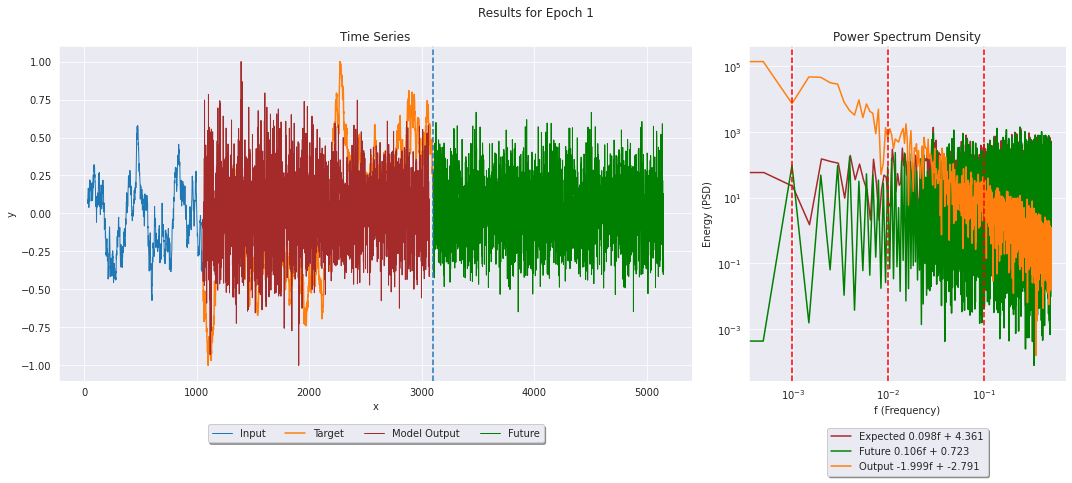

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Epoch: 1, Train Loss: nan, Validation Loss: nan, Time 2.868 s


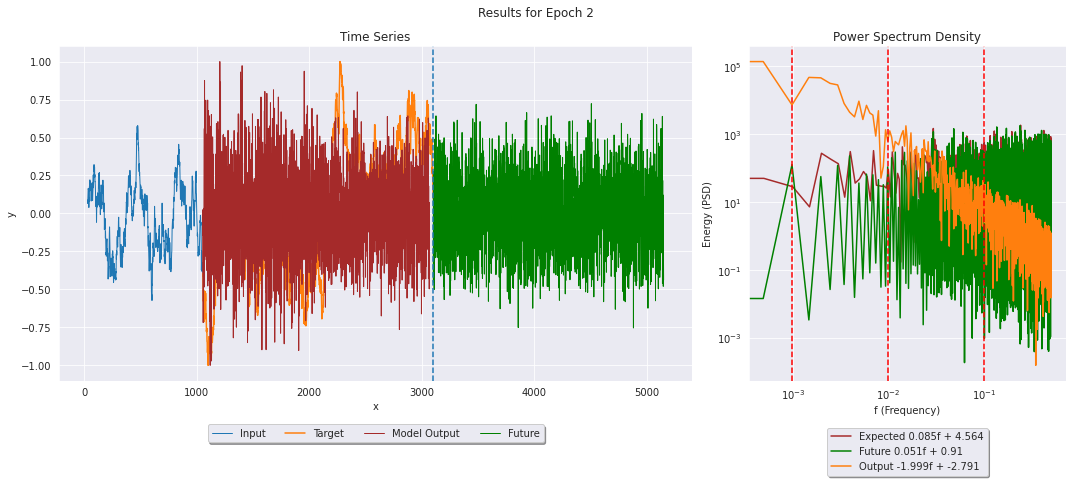

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Epoch: 2, Train Loss: nan, Validation Loss: nan, Time 1.918 s


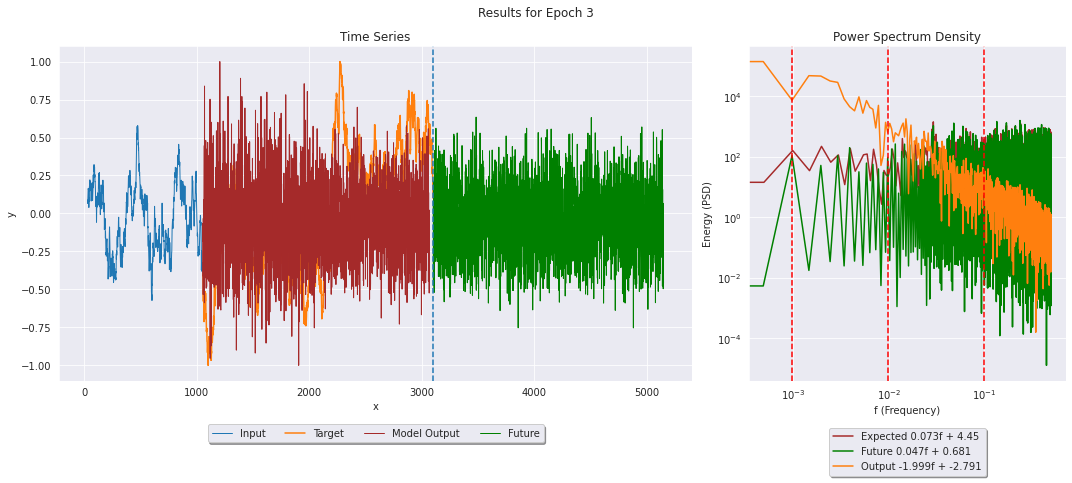

Epoch: 3, Train Loss: nan, Validation Loss: nan, Time 1.851 s


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


array(nan, dtype=float32)

In [90]:
n_cut = 3
title = 'MLP'
epochs = 3
low_freq_cut= 0
high_freq_cut= 0

day = datetime.date.today()

model = MLP(n_layers = 3,
             hidden_layers=[1024,1024,1024],
             activations=['tanh','tanh','tanh','tanh'],
             dropouts=[0.0,0.0,0.00,0.0],
            output_size=len(trainY[0])-len(trainX[0]),
            isGNI=True)
#model = MLP(output_size=len(trainY[0]))

optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
  # for n_cut in range(1,6):
l = DBeta(n_cut,
          low_freq_cut=low_freq_cut,
          high_freq_cut=high_freq_cut)
training_loop(epochs,
              model, l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              optimiser = 'LBFGS',
              future=len(trainY[0]),
              n_cut=n_cut,
              lr = 0.01,
              plot_results_during_traing=True,
              save_results = True,
              verbose = True,
              file_name=f'RESULTS_{day}_{title}_ncut{n_cut}_.plk')
              
              

### MLP Optuna

In [89]:
day = datetime.date.today()
def objective(trial):
    epochs        = 3
    low_freq_cut  = 0
    high_freq_cut = 0
    
    neuron_min = 128
    neuron_max = 1024

    drop_max = 0.9
    drop_min = 0.0


    n_layers      = trial.suggest_int('n_layers', 2, 5)
    n_cut         = trial.suggest_int('n_cut', 1, 5)

    hidden_layers1 = trial.suggest_int('hidden_layers1', neuron_min, neuron_max)
    hidden_layers2 = trial.suggest_int('hidden_layers2', neuron_min, neuron_max)
    hidden_layers3 = trial.suggest_int('hidden_layers3', neuron_min, neuron_max)
    hidden_layers4 = trial.suggest_int('hidden_layers4', neuron_min, neuron_max)
    hidden_layers5 = trial.suggest_int('hidden_layers5', neuron_min, neuron_max)
    
    activations1    = trial.suggest_categorical('activations1',["sigmoid", "relu", "tanh"])
    activations2    = trial.suggest_categorical('activations2',["sigmoid", "relu", "tanh"])
    activations3    = trial.suggest_categorical('activations3',["sigmoid", "relu", "tanh"])
    activations4    = trial.suggest_categorical('activations4',["sigmoid", "relu", "tanh"])
    activations5    = trial.suggest_categorical('activations5',["sigmoid", "relu", "tanh"])
    
    dropout1       = trial.suggest_float('dropout1', drop_min, drop_max)
    dropout2       = trial.suggest_float('dropout2', drop_min, drop_max)
    dropout3       = trial.suggest_float('dropout3', drop_min, drop_max)
    dropout4       = trial.suggest_float('dropout4', drop_min, drop_max)
    dropout5       = trial.suggest_float('dropout5', drop_min, drop_max)

    lr             = trial.suggest_float('lr', 1e-4, 5e-1)
    
    #optimiser    = trial.suggest_categorical('optimiser',["LBFGS", "Adam", "SGD"])

    model = MLP(hidden_layers = [hidden_layers1,hidden_layers2,hidden_layers3, hidden_layers4,hidden_layers5],
             activations     = [activations1,activations2,activations3,activations4,activations5],
             #activations      = ['sigmoid','relu','tanh','tanh','tanh'],
             dropouts         = [dropout1,dropout2,dropout3,dropout4,dropout5],
            output_size       = len(trainY[0])-len(trainX[0]),
            isGNI=True)
    optimiser      = trial.suggest_categorical('optimiser',['LBFGS','SGD_','Adam_'])
                                                           

    #optimiser = torch.optim.LBFGS(model.parameters(), lr=lr)
    l = DBeta(n_cut,
              low_freq_cut=low_freq_cut,
              high_freq_cut=high_freq_cut)
    
    loss = training_loop(epochs,
                         model, 
                         l, 
                         trainX.float(), trainY.float(), 
                         trainX_test.float(), trainY_test.float(),
                         optimiser = optimiser[0],
                         future=len(trainY[0]),
                         n_cut=n_cut,
                         lr = lr,
                         plot_results_during_traing=False,
                         save_results = False,
                         verbose = False,
                         file_name=f'RESULTS_{day}_{title}_ncut{n_cut}_.plk')
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print(f'Best trial: {day}', study.best_trial.params)

[I 2022-11-18 18:44:56,008] A new study created in memory with name: no-name-7be6b136-3e9e-4b5a-b20d-aa573e808e3f
[I 2022-11-18 18:44:56,238] Trial 0 finished with value: 2.965089797973633 and parameters: {'n_layers': 5, 'n_cut': 2, 'hidden_layers1': 782, 'hidden_layers2': 231, 'hidden_layers3': 145, 'hidden_layers4': 281, 'hidden_layers5': 782, 'activations1': 'tanh', 'activations2': 'relu', 'activations3': 'tanh', 'activations4': 'sigmoid', 'activations5': 'sigmoid', 'dropout1': 0.07469970221662252, 'dropout2': 0.018272528900023576, 'dropout3': 0.6787534320698102, 'dropout4': 0.6767503578561727, 'dropout5': 0.8422422497533294, 'lr': 0.49790438600406783, 'optimiser': 'LBFGS'}. Best is trial 0 with value: 2.965089797973633.
[I 2022-11-18 18:44:56,466] Trial 1 finished with value: 2.9875376224517822 and parameters: {'n_layers': 3, 'n_cut': 1, 'hidden_layers1': 995, 'hidden_layers2': 248, 'hidden_layers3': 237, 'hidden_layers4': 180, 'hidden_layers5': 538, 'activations1': 'relu', 'activa

Number of finished trials: 10
Best trial:2022-11-18 {'n_layers': 2, 'n_cut': 1, 'hidden_layers1': 455, 'hidden_layers2': 332, 'hidden_layers3': 840, 'hidden_layers4': 390, 'hidden_layers5': 317, 'activations1': 'sigmoid', 'activations2': 'sigmoid', 'activations3': 'relu', 'activations4': 'relu', 'activations5': 'tanh', 'dropout1': 0.8779726185030949, 'dropout2': 0.38825964189915746, 'dropout3': 0.3746806113947223, 'dropout4': 0.12547754483083803, 'dropout5': 0.07470796904496178, 'lr': 0.11055957964512027, 'optimiser': 'LBFGS'}


## E2 - RNN

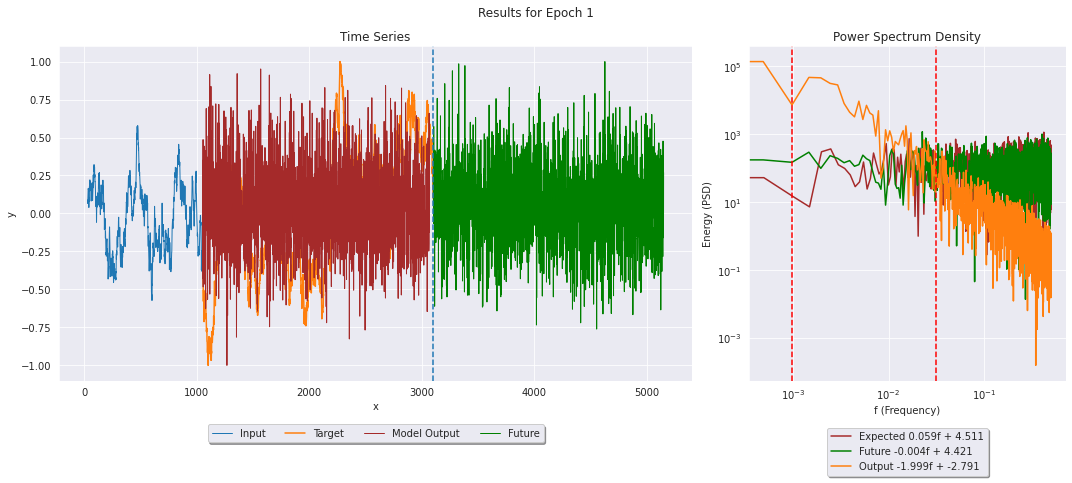

Epoch: 1, Train Loss: 4.79122, Validation Loss: 4.16293, Time 5.395 s


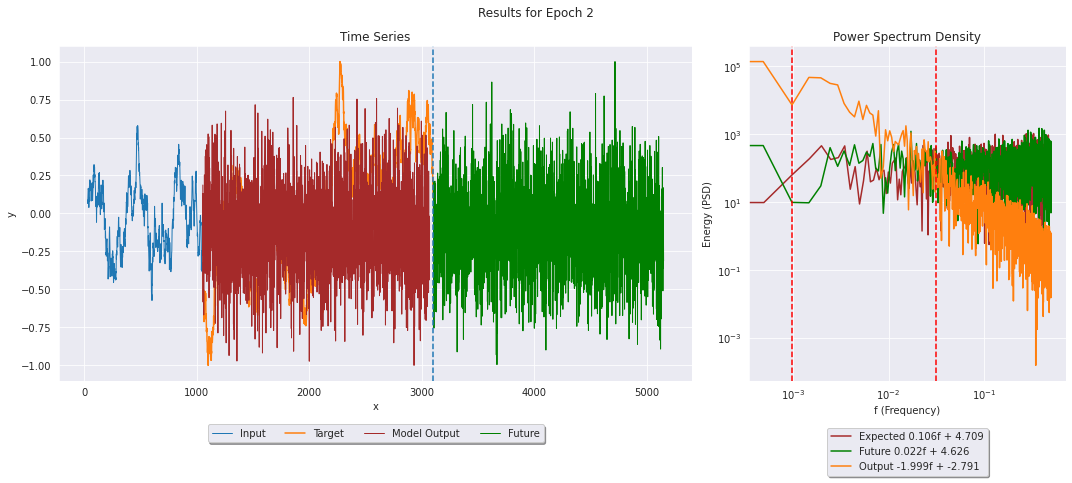

Epoch: 2, Train Loss: 4.80032, Validation Loss: 3.84495, Time 5.331 s


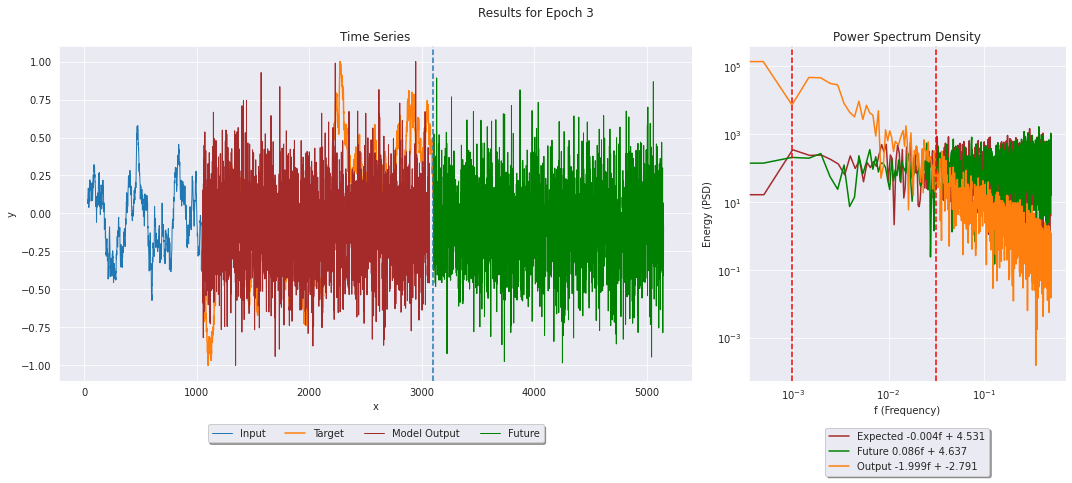

Epoch: 3, Train Loss: 4.95901, Validation Loss: 3.77949, Time 5.176 s


array(3.7794871, dtype=float32)

In [ ]:
n_cut         = 2
epochs        = 3
low_freq_cut  = 0
high_freq_cut = 0
#model = RNN_GNI(hidden_layers=32,isGNI=False)
model = RNN(n_layers      = 3, 
                 hidden_layers = [32,64,64,64,54],
                 dropouts      = [0.1,0.1,0.1,0.1,0],
                 isGNI         = True)
title = 'RNN'

#optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)#,momentum=0.9)
#optimiser = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.9)
l = DBeta(n_cut,
          low_freq_cut  = low_freq_cut,
          high_freq_cut = high_freq_cut)

training_loop(epochs,
              model, l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              optimiser = 'LBFGS',
              future=len(trainY[0]),
              n_cut=n_cut,
              lr = 0.01,
              plot_results_during_traing=True,
              save_results = True,
              verbose = True,
              file_name=f'RESULTS_{day}_{title}_ncut{n_cut}_.plk')
              

### RNN Optuna

In [ ]:
trials = 10
def objective(trial):
    epochs        = 3
    low_freq_cut  = 0
    high_freq_cut = 0
    
    neuron_min = 128
    neuron_max = 1024

    drop_max = 0.9
    drop_min = 0.0


    n_layers      = trial.suggest_int('n_layers', 1, 5)
    n_cut         = trial.suggest_int('n_cut', 1, 5)

    hidden_layers1 = trial.suggest_int('hidden_layers1', neuron_min, neuron_max)
    hidden_layers2 = trial.suggest_int('hidden_layers2', neuron_min, neuron_max)
    hidden_layers3 = trial.suggest_int('hidden_layers3', neuron_min, neuron_max)
    hidden_layers4 = trial.suggest_int('hidden_layers4', neuron_min, neuron_max)
    hidden_layers5 = trial.suggest_int('hidden_layers5', neuron_min, neuron_max)
    #activations   = trial.suggest_categorical('activations',['sigmoid', 'relu', 'tanh']),
    
    dropout1       = trial.suggest_float('dropout1', drop_min, drop_max)
    dropout2       = trial.suggest_float('dropout2', drop_min, drop_max)
    dropout3       = trial.suggest_float('dropout3', drop_min, drop_max)
    dropout4       = trial.suggest_float('dropout4', drop_min, drop_max)
    dropout5       = trial.suggest_float('dropout5', drop_min, drop_max)

    lr             = trial.suggest_float('lr', 1e-4, 5e-1)

    model = RNN_GNI2(n_layers       = n_layers,
                     hidden_layers  = [hidden_layers1,hidden_layers2,hidden_layers3, hidden_layers4,hidden_layers5],
                    #activations     = [activations,activations,activations,activations,activations],
                    activations      = ['sigmoid'],
                    dropouts         = [dropout1,dropout2,dropout3,dropout4,dropout5],
                    isGNI=True)
    optimiser = torch.optim.LBFGS(model.parameters(), 
                                  lr=lr)
    l = DBeta(n_cut,
              low_freq_cut=low_freq_cut,
              high_freq_cut=high_freq_cut)
    
    loss = training_loop(epochs,model, optimiser,l, 
                  trainX.float(), trainY.float(), 
                  trainX_test.float(), trainY_test.float(),
                  future=len(trainY[0]),
                  n_cut=n_cut,
                  plot_results_during_traing=False,
                  save_results = False,
                  verbose = False,
                  file_name=f'optuna_MLP_ncut{n_cut}_GNI.plk')
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-11-16 20:55:19,135] A new study created in memory with name: no-name-3355e043-0c0d-4b5a-8864-a522b80ae2ae
[W 2022-11-16 21:00:03,858] Trial 0 failed because of the following error: The value nan is not acceptable.
[W 2022-11-16 21:08:11,872] Trial 1 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-166-7dba50e083de>", line 52, in objective
    file_name=f'optuna_MLP_ncut{n_cut}_GNI.plk')
  File "<ipython-input-52-8a54a881e2c8>", line 44, in training_loop
    optimiser.step(closure) #Call the funcution
  File "/usr/local/lib/python3.7/dist-packages/torch/optim/optimizer.py", line 113, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local

KeyboardInterrupt: ignored

In [ ]:
i = 0
x = df[~df.trainX.isnull()].trainX
y = df[~df.trainY.isnull()].trainY
z = df[~df[f'out{i+1}'].isnull()][f'out{i+1}']
w = df[~df[f'fut{i+1}'].isnull()][f'fut{i+1}']
plot_results(x,y,z,w,32,i)

## E3 - LSTM

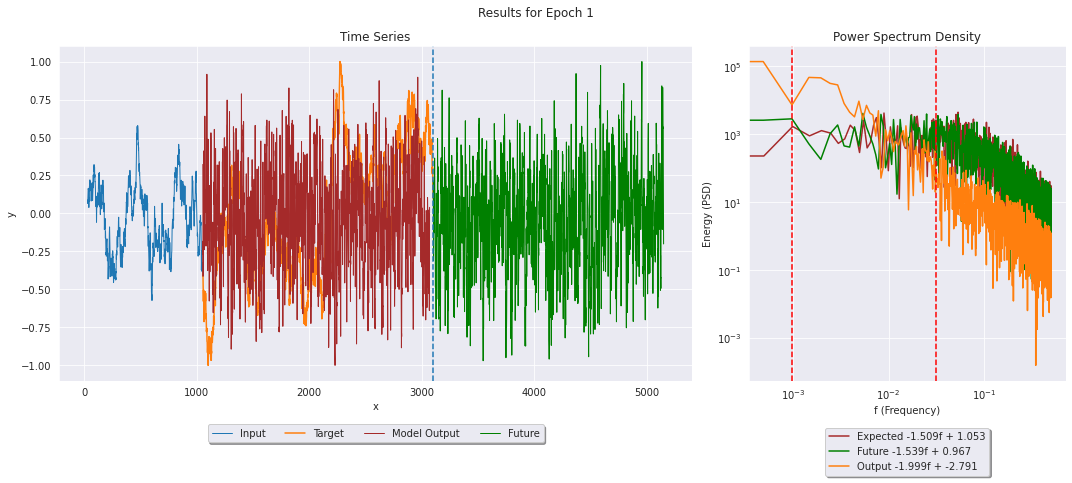

Epoch: 1, Train Loss: 1.39192, Validation Loss: 0.975, Time 6.056 s


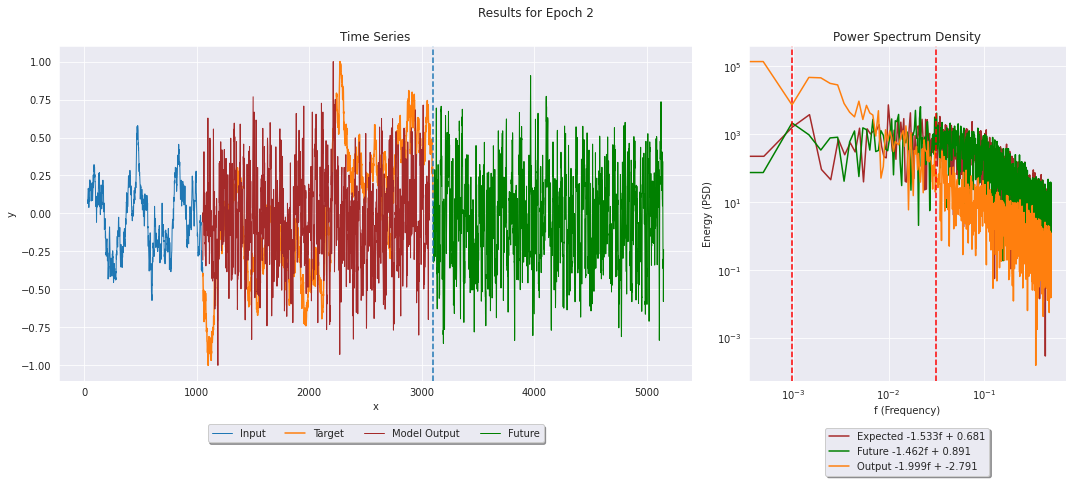

Epoch: 2, Train Loss: 1.60267, Validation Loss: 0.88815, Time 8.599 s


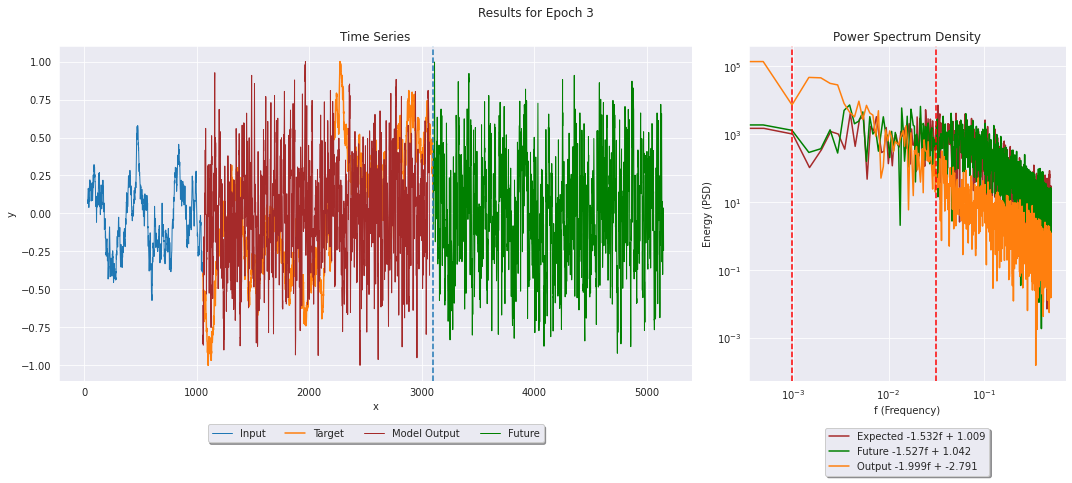

Epoch: 3, Train Loss: 1.68482, Validation Loss: 0.95904, Time 6.23 s


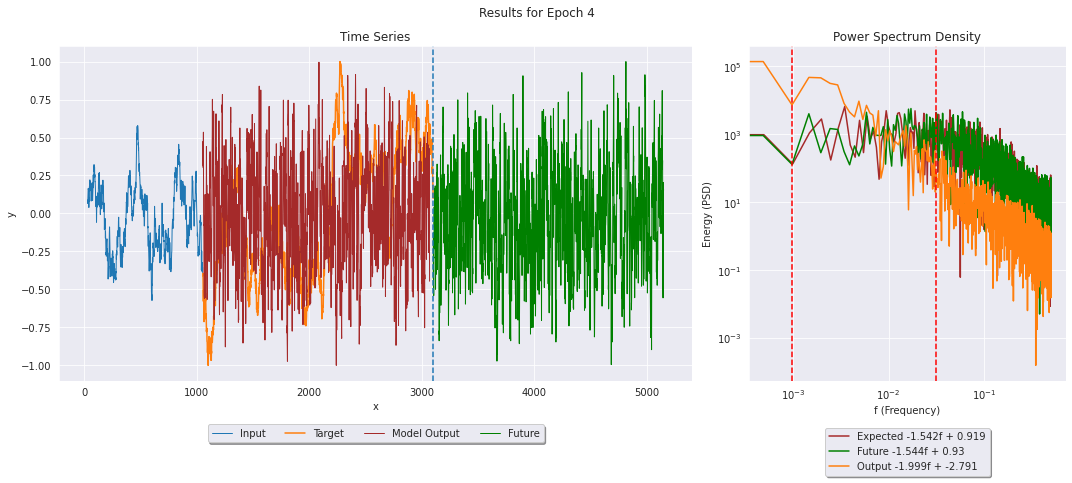

Epoch: 4, Train Loss: 1.60196, Validation Loss: 0.88369, Time 5.745 s


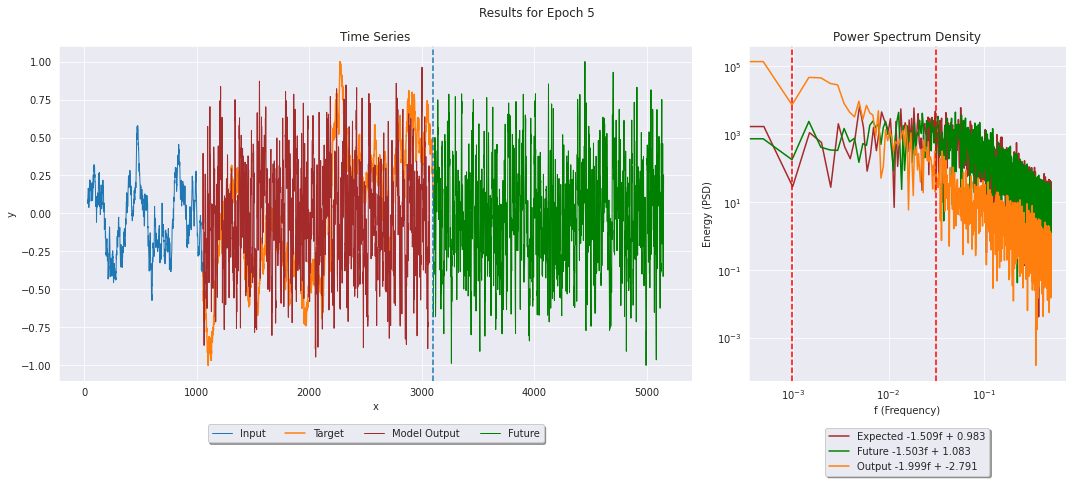

Epoch: 5, Train Loss: 1.59808, Validation Loss: 0.95275, Time 6.299 s


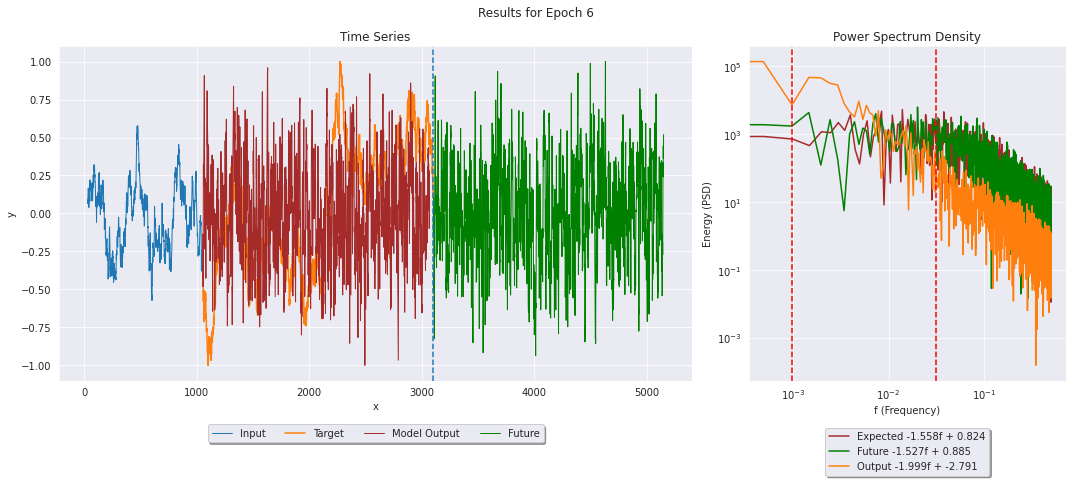

Epoch: 6, Train Loss: 1.54247, Validation Loss: 0.9489, Time 6.143 s


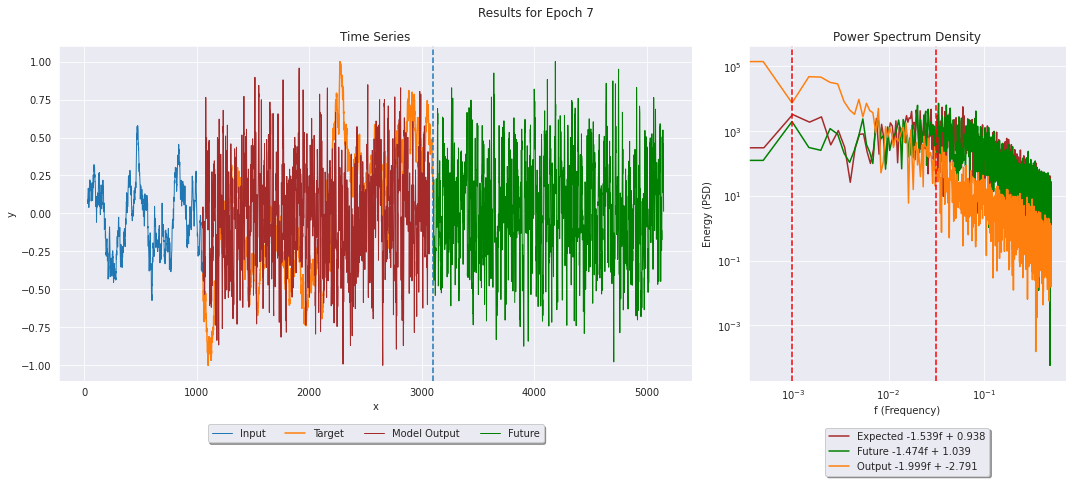

Epoch: 7, Train Loss: 1.53273, Validation Loss: 0.84137, Time 5.738 s


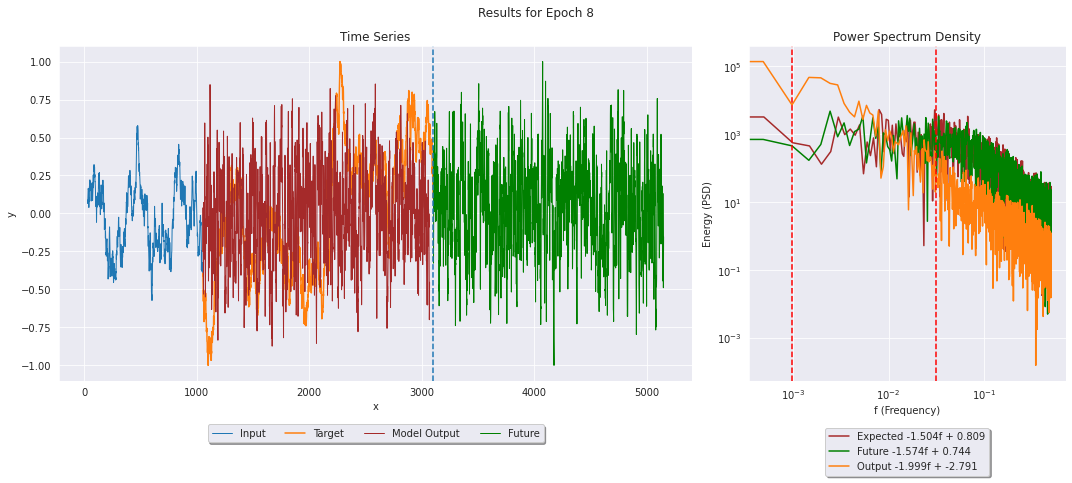

Epoch: 8, Train Loss: 1.56528, Validation Loss: 0.98788, Time 5.667 s


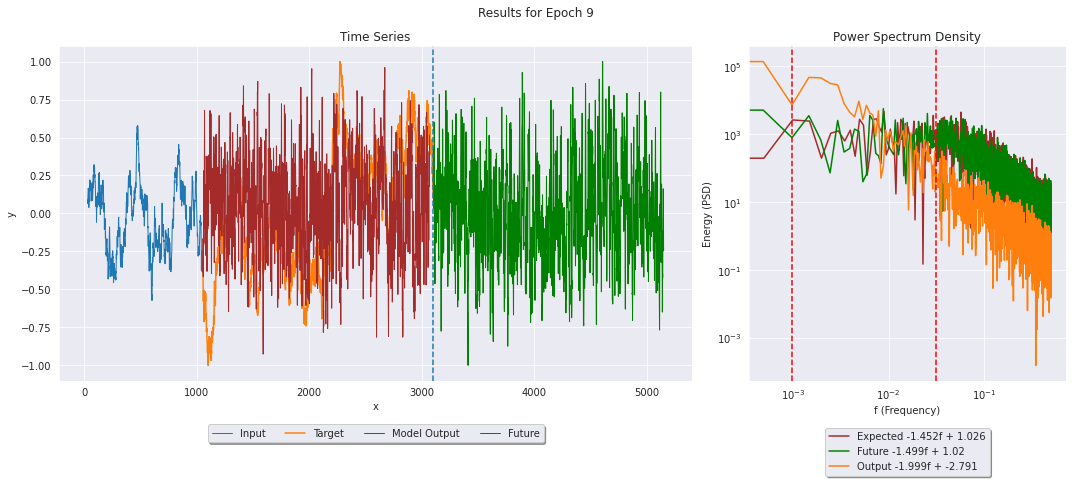

Epoch: 9, Train Loss: 1.6885, Validation Loss: 1.10697, Time 5.754 s


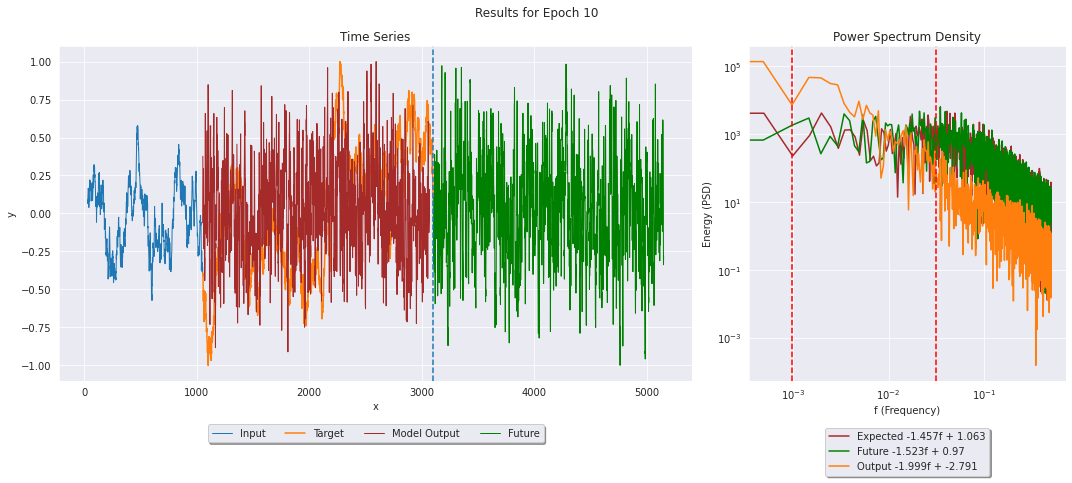

Epoch: 10, Train Loss: 1.5068, Validation Loss: 0.87398, Time 5.604 s


array(0.8739788, dtype=float32)

In [ ]:
n_cut         = 2
epochs        = 10
low_freq_cut  = 0
high_freq_cut = 0
#model = LSTM_GNI(hidden_layers=32,isGNI=False)
model = LSTM(n_layers      = 2, 
                 hidden_layers = [64,64,32,64,54],
                 dropouts      = [0.0,0.0,0.0,0.1,0],
                 isGNI         = True)
title = 'LSTM'

#optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)#,momentum=0.9)
#optimiser = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.9)
l = DBeta(n_cut,
          low_freq_cut  = low_freq_cut,
          high_freq_cut = high_freq_cut)

training_loop(epochs,
              model, l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              optimiser = 'LBFGS',
              future=len(trainY[0]),
              n_cut=n_cut,
              lr = 0.01,
              plot_results_during_traing=True,
              save_results = True,
              verbose = True,
              file_name=f'RESULTS_{day}_{title}_ncut{n_cut}_.plk')
              

### LSTM Optuna

In [ ]:
trials = 2
def objective(trial):
    epochs        = 3
    low_freq_cut  = 0
    high_freq_cut = 0
    
    neuron_min = 32
    neuron_max = 64

    drop_max = 0.9
    drop_min = 0.0


    n_layers      = trial.suggest_int('n_layers', 1, 5)
    n_cut         = trial.suggest_int('n_cut', 1, 2)

    hidden_layers1 = trial.suggest_int('hidden_layers1', neuron_min, neuron_max)
    hidden_layers2 = trial.suggest_int('hidden_layers2', neuron_min, neuron_max)
    hidden_layers3 = trial.suggest_int('hidden_layers3', neuron_min, neuron_max)
    hidden_layers4 = trial.suggest_int('hidden_layers4', neuron_min, neuron_max)
    hidden_layers5 = trial.suggest_int('hidden_layers5', neuron_min, neuron_max)
    #activations   = trial.suggest_categorical('activations',['sigmoid', 'relu', 'tanh']),
    
    dropout1       = trial.suggest_float('dropout1', drop_min, drop_max)
    dropout2       = trial.suggest_float('dropout2', drop_min, drop_max)
    dropout3       = trial.suggest_float('dropout3', drop_min, drop_max)
    dropout4       = trial.suggest_float('dropout4', drop_min, drop_max)
    dropout5       = trial.suggest_float('dropout5', drop_min, drop_max)

    lr             = trial.suggest_float('lr', 1e-4, 5e-1)

    model = LSTM_GNI2(n_layers       = n_layers,
                     hidden_layers  = [hidden_layers1,hidden_layers2,hidden_layers3, hidden_layers4,hidden_layers5],
                    #activations     = [activations,activations,activations,activations,activations],
                    activations      = ['sigmoid'],
                    dropouts         = [dropout1,dropout2,dropout3,dropout4,dropout5],
                    isGNI=True)
    optimiser = torch.optim.LBFGS(model.parameters(), 
                                  lr=lr)
    l = DBeta(n_cut,
              low_freq_cut=low_freq_cut,
              high_freq_cut=high_freq_cut)
    
    loss = training_loop(epochs,model, optimiser,l, 
                  trainX.float(), trainY.float(), 
                  trainX_test.float(), trainY_test.float(),
                  future=len(trainY[0]),
                  n_cut=n_cut,
                  plot_results_during_traing=False,
                  save_results = False,
                  verbose = False,
                  file_name=f'optuna_MLP_ncut{n_cut}_GNI.plk')
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-11-16 14:14:39,411] A new study created in memory with name: no-name-155f0064-1c22-447d-9408-12a56fe9f88d
[W 2022-11-16 14:19:21,816] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-51-3fc095dcb1c0>", line 52, in objective
    file_name=f'optuna_MLP_ncut{n_cut}_GNI.plk')
  File "<ipython-input-17-8a54a881e2c8>", line 44, in training_loop
    optimiser.step(closure) #Call the funcution
  File "/usr/local/lib/python3.7/dist-packages/torch/optim/optimizer.py", line 113, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/optim/lbfgs.py", line 437, in step
    loss = float(closure())
  File "/us

KeyboardInterrupt: ignored

## E4 - GRU

In [95]:
n_cut         = 2
epochs        = 3
low_freq_cut  = 0
high_freq_cut = 0
#model = RNN_GNI(hidden_layers=32,isGNI=False)
model = GRU(n_layers      = 2, 
                 hidden_layers = [64,64,64,64,54],
                 dropouts      = [0.1,0.1,0.1,0.1,0],
                 isGNI         = True)
title = 'GRU'

#optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)#,momentum=0.9)
#optimiser = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.9)
l = DBeta(n_cut,
          low_freq_cut  = low_freq_cut,
          high_freq_cut = high_freq_cut)

training_loop(epochs,
              model, l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              optimiser = 'LBFGS',
              future=len(trainY[0]),
              n_cut=n_cut,
              lr = 0.01,
              plot_results_during_traing=True,
              save_results = True,
              verbose = True,
              file_name=f'RESULTS_{day}_{title}_ncut{n_cut}_.plk')
              

TypeError: ignored

### GRU Optuna



In [ ]:
trials = 10
def objective(trial):
    epochs        = 3
    low_freq_cut  = 0
    high_freq_cut = 0
    
    neuron_min = 32
    neuron_max = 34

    drop_max = 0.9
    drop_min = 0.0


    n_layers      = trial.suggest_int('n_layers', 1, 2)
    n_cut         = trial.suggest_int('n_cut', 1, 2)

    hidden_layers1 = trial.suggest_int('hidden_layers1', neuron_min, neuron_max)
    hidden_layers2 = trial.suggest_int('hidden_layers2', neuron_min, neuron_max)
    hidden_layers3 = trial.suggest_int('hidden_layers3', neuron_min, neuron_max)
    hidden_layers4 = trial.suggest_int('hidden_layers4', neuron_min, neuron_max)
    hidden_layers5 = trial.suggest_int('hidden_layers5', neuron_min, neuron_max)
    #activations   = trial.suggest_categorical('activations',['sigmoid', 'relu', 'tanh']),
    
    dropout1       = trial.suggest_float('dropout1', drop_min, drop_max)
    dropout2       = trial.suggest_float('dropout2', drop_min, drop_max)
    dropout3       = trial.suggest_float('dropout3', drop_min, drop_max)
    dropout4       = trial.suggest_float('dropout4', drop_min, drop_max)
    dropout5       = trial.suggest_float('dropout5', drop_min, drop_max)

    lr             = trial.suggest_float('lr', 1e-4, 5e-1)

    model = GRU_GNI2(n_layers       = n_layers,
                     hidden_layers  = [hidden_layers1,hidden_layers2,hidden_layers3, hidden_layers4,hidden_layers5],
                    #activations     = [activations,activations,activations,activations,activations],
                    activations      = ['sigmoid'],
                    dropouts         = [dropout1,dropout2,dropout3,dropout4,dropout5],
                    isGNI=True)
    optimiser = torch.optim.LBFGS(model.parameters(), 
                                  lr=lr)
    l = DBeta(n_cut,
              low_freq_cut=low_freq_cut,
              high_freq_cut=high_freq_cut)
    
    loss = training_loop(epochs,model, optimiser,l, 
                  trainX.float(), trainY.float(), 
                  trainX_test.float(), trainY_test.float(),
                  future=len(trainY[0]),
                  n_cut=n_cut,
                  plot_results_during_traing=False,
                  save_results = False,
                  verbose = False,
                  file_name=f'optuna_MLP_ncut{n_cut}_GNI.plk')
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-11-16 15:07:25,313] A new study created in memory with name: no-name-129b4bbd-e34b-4ec8-b772-d52ca47eee49
[I 2022-11-16 15:08:53,058] Trial 0 finished with value: 5.3263020515441895 and parameters: {'n_layers': 2, 'n_cut': 1, 'hidden_layers1': 34, 'hidden_layers2': 34, 'hidden_layers3': 33, 'hidden_layers4': 32, 'hidden_layers5': 33, 'dropout1': 0.45093931585979297, 'dropout2': 0.4932919972803247, 'dropout3': 0.5484001088831199, 'dropout4': 0.7177100393395979, 'dropout5': 0.56312000175935, 'lr': 0.18639850087226237}. Best is trial 0 with value: 5.3263020515441895.
[I 2022-11-16 15:10:05,170] Trial 1 finished with value: 0.5207642912864685 and parameters: {'n_layers': 2, 'n_cut': 1, 'hidden_layers1': 33, 'hidden_layers2': 32, 'hidden_layers3': 34, 'hidden_layers4': 33, 'hidden_layers5': 34, 'dropout1': 0.11107990530498846, 'dropout2': 0.3218577889005734, 'dropout3': 0.5193328376347065, 'dropout4': 0.17946892246480403, 'dropout5': 0.4844101568154005, 'lr': 0.47541285770012726}. B

Number of finished trials: 10
Best trial: {'n_layers': 2, 'n_cut': 1, 'hidden_layers1': 33, 'hidden_layers2': 32, 'hidden_layers3': 34, 'hidden_layers4': 33, 'hidden_layers5': 34, 'dropout1': 0.11107990530498846, 'dropout2': 0.3218577889005734, 'dropout3': 0.5193328376347065, 'dropout4': 0.17946892246480403, 'dropout5': 0.4844101568154005, 'lr': 0.47541285770012726}


## E5 - CNN

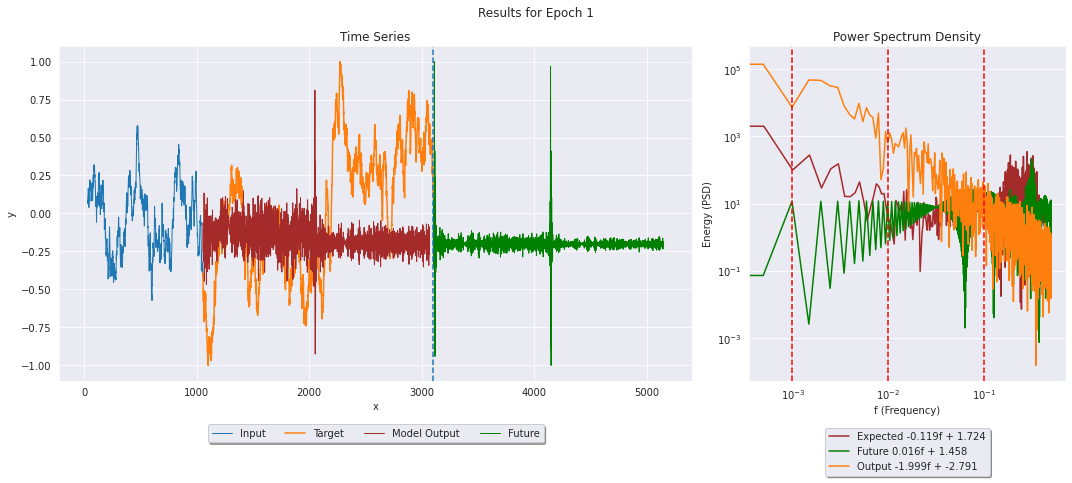

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Epoch: 1, Train Loss: 3.2371, Validation Loss: 2.73518, Time 1.609 s


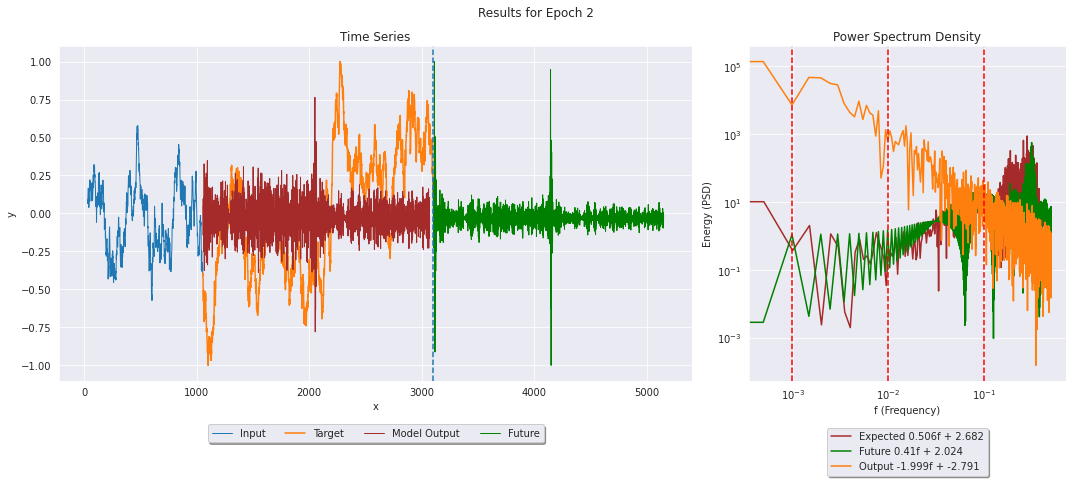

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Epoch: 2, Train Loss: 4.06607, Validation Loss: 3.27866, Time 1.474 s


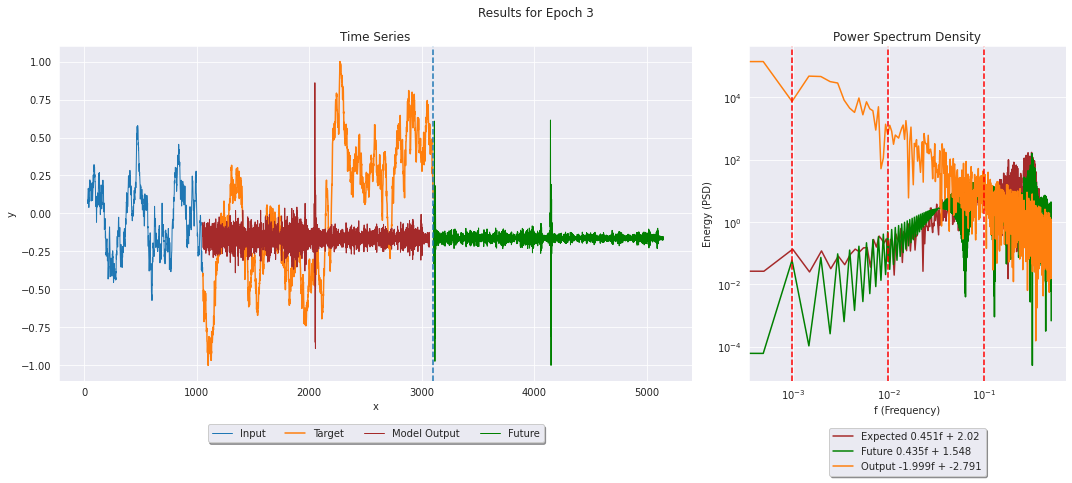

Epoch: 3, Train Loss: 3.6112, Validation Loss: 2.8702, Time 1.447 s


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


array(2.8701975, dtype=float32)

In [209]:
n_cut         = 3
title         = 'CNN'
epochs        = 3
low_freq_cut  = 1
high_freq_cut = 1

model = CNN(n_layers=2, 
                 activations=['tanh','tanh','const','sigmoid','sigmoid','sigmoid'],
                 dropouts=[0.0,0.0,0,0,0,0,0,0], 
                 #isGNI=True,
                 in_channels =[3,5,7,3,3],
                 kernel_size =[5,5,5,3,3,3,3,3],
                 stride      =[1,1,1,1,1,1,1,1])

optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
l = DBeta(n_cut,
          low_freq_cut=low_freq_cut,
          high_freq_cut=high_freq_cut)
training_loop(epochs,
              model, l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              optimiser = 'Adam',
              future=len(trainY[0]),
              n_cut=n_cut,
              lr = 0.01,
              plot_results_during_traing = True,
              save_results               = True,
              verbose                    = True,
              file_name=f'RESULTS_{day}_{title}_ncut{n_cut}_.plk')
              

### CNN - Optuna

In [226]:
day = datetime.date.today()
def objective(trial):
    epochs        = 15
    low_freq_cut  = 0
    high_freq_cut = 0
    
    neuron_min = 128
    neuron_max = 1024

    drop_max = 0.9
    drop_min = 0.0


    n_layers      = trial.suggest_int('n_layers', 1, 5)
    n_cut         = trial.suggest_int('n_cut', 1, 5)

    
    activations1    = trial.suggest_categorical('activations1',["sigmoid", "relu", "tanh","const"])
    activations2    = trial.suggest_categorical('activations2',["sigmoid", "relu", "tanh","const"])
    activations3    = trial.suggest_categorical('activations3',["sigmoid", "relu", "tanh","const"])
    activations4    = trial.suggest_categorical('activations4',["sigmoid", "relu", "tanh","const"])
    activations5    = trial.suggest_categorical('activations5',["sigmoid", "relu", "tanh","const"])
    
    dropout1       = trial.suggest_float('dropout1', drop_min, drop_max)
    dropout2       = trial.suggest_float('dropout2', drop_min, drop_max)
    dropout3       = trial.suggest_float('dropout3', drop_min, drop_max)
    dropout4       = trial.suggest_float('dropout4', drop_min, drop_max)
    dropout5       = trial.suggest_float('dropout5', drop_min, drop_max)

    optimiser      = trial.suggest_categorical('optimiser',['LBFGS','SGD','Adam'])

    kernel_size1    = 2*trial.suggest_int('kernel_size1', 1, 3) +1
    kernel_size2    = 2*trial.suggest_int('kernel_size2', 1, 3) +1
    kernel_size3    = 2*trial.suggest_int('kernel_size3', 1, 3) +1
    kernel_size4    = 2*trial.suggest_int('kernel_size4', 1, 3) +1
    kernel_size5    = 2*trial.suggest_int('kernel_size5', 1, 3) +1

    in_channels1    = 2*(kernel_size1 + trial.suggest_int('in_channels1', 1, 3))+1
    in_channels2    = 2*(kernel_size2 + trial.suggest_int('in_channels2', 1, 3))+1
    in_channels3    = 2*(kernel_size3 + trial.suggest_int('in_channels3', 1, 3))+1
    in_channels4    = 2*(kernel_size4 + trial.suggest_int('in_channels4', 1, 3))+1
    in_channels5    = 2*(kernel_size5 + trial.suggest_int('in_channels5', 1, 3))+1

    lr             = trial.suggest_float('lr', 1e-4, 5e-1)

    print(n_layers)
    print([in_channels1,in_channels2,in_channels3,in_channels4,in_channels5])
    print([kernel_size1,kernel_size2,kernel_size3,kernel_size4,kernel_size5])
    print("-------")
    model = CNN(n_layers=n_layers, 
                 activations     = [activations1,activations2,activations3,activations4,activations5],
                 dropouts        = [dropout1,dropout2,dropout3,dropout4,dropout5],
                 in_channels     = [in_channels1,in_channels2,in_channels3,in_channels4,in_channels5],
                 kernel_size     = [kernel_size1,kernel_size2,kernel_size3,kernel_size4,kernel_size5],
                 stride          = [1,1,1,1,1,1,1,1,1])
   
                                                           

    #optimiser = torch.optim.LBFGS(model.parameters(), lr=lr)
    l = DBeta(n_cut,
              low_freq_cut=low_freq_cut,
              high_freq_cut=high_freq_cut)
    
    loss = training_loop(epochs,
                         model, 
                         l, 
                         trainX.float(), trainY.float(), 
                         trainX_test.float(), trainY_test.float(),
                         optimiser = optimiser[0],
                         future=len(trainY[0]),
                         n_cut=n_cut,
                         lr = lr,
                         plot_results_during_traing=False,
                         save_results = False,
                         verbose = False,
                         file_name=f'RESULTS_{day}_{title}_ncut{n_cut}_.plk')
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print(f'Best trial: {day}', study.best_trial.params)

[I 2022-11-18 21:51:57,015] A new study created in memory with name: no-name-247546cd-c9f6-438a-a568-87b187b91b1f


5
[17, 13, 21, 19, 13]
[5, 5, 7, 7, 5]
-------


[W 2022-11-18 21:52:04,040] Trial 0 failed because of the following error: The value nan is not acceptable.


1
[17, 21, 19, 19, 21]
[5, 7, 7, 7, 7]
-------


[W 2022-11-18 21:52:05,613] Trial 1 failed because of the following error: The value nan is not acceptable.


3
[13, 9, 17, 13, 9]
[3, 3, 5, 5, 3]
-------


[W 2022-11-18 21:52:08,076] Trial 2 failed because of the following error: The value nan is not acceptable.


5
[13, 11, 17, 9, 11]
[5, 3, 5, 3, 3]
-------


[I 2022-11-18 21:52:11,372] Trial 3 finished with value: 1.7488600015640259 and parameters: {'n_layers': 5, 'n_cut': 2, 'activations1': 'relu', 'activations2': 'sigmoid', 'activations3': 'relu', 'activations4': 'tanh', 'activations5': 'relu', 'dropout1': 0.7424214648244506, 'dropout2': 0.2749991237985975, 'dropout3': 0.6864892104745807, 'dropout4': 0.6575320628805067, 'dropout5': 0.5899169145542829, 'optimiser': 'LBFGS', 'kernel_size1': 2, 'kernel_size2': 1, 'kernel_size3': 2, 'kernel_size4': 1, 'kernel_size5': 1, 'in_channels1': 1, 'in_channels2': 2, 'in_channels3': 3, 'in_channels4': 1, 'in_channels5': 2, 'lr': 0.45403433228338835}. Best is trial 3 with value: 1.7488600015640259.


1
[13, 11, 19, 15, 21]
[5, 3, 7, 5, 7]
-------


[W 2022-11-18 21:52:12,584] Trial 4 failed because of the following error: The value nan is not acceptable.


3
[9, 21, 11, 15, 19]
[3, 7, 3, 5, 7]
-------


[W 2022-11-18 21:52:15,256] Trial 5 failed because of the following error: The value nan is not acceptable.


5
[19, 21, 11, 15, 11]
[7, 7, 3, 5, 3]
-------


[I 2022-11-18 21:52:19,747] Trial 6 finished with value: 3.2369370460510254 and parameters: {'n_layers': 5, 'n_cut': 2, 'activations1': 'tanh', 'activations2': 'const', 'activations3': 'sigmoid', 'activations4': 'const', 'activations5': 'sigmoid', 'dropout1': 0.5357568504969861, 'dropout2': 0.16767211590128211, 'dropout3': 0.8287843349283618, 'dropout4': 0.0839439160595344, 'dropout5': 0.10006329664159824, 'optimiser': 'Adam', 'kernel_size1': 3, 'kernel_size2': 3, 'kernel_size3': 1, 'kernel_size4': 2, 'kernel_size5': 1, 'in_channels1': 2, 'in_channels2': 3, 'in_channels3': 2, 'in_channels4': 2, 'in_channels5': 2, 'lr': 0.06961830835187749}. Best is trial 3 with value: 1.7488600015640259.


1
[11, 19, 13, 21, 17]
[3, 7, 3, 7, 5]
-------


[I 2022-11-18 21:52:20,654] Trial 7 finished with value: 6.008559703826904 and parameters: {'n_layers': 1, 'n_cut': 2, 'activations1': 'tanh', 'activations2': 'const', 'activations3': 'tanh', 'activations4': 'sigmoid', 'activations5': 'relu', 'dropout1': 0.4772638618322692, 'dropout2': 0.3932664153979126, 'dropout3': 0.7024697682060143, 'dropout4': 0.1855506226318741, 'dropout5': 0.2084392891079542, 'optimiser': 'Adam', 'kernel_size1': 1, 'kernel_size2': 3, 'kernel_size3': 1, 'kernel_size4': 3, 'kernel_size5': 2, 'in_channels1': 2, 'in_channels2': 2, 'in_channels3': 3, 'in_channels4': 3, 'in_channels5': 3, 'lr': 0.39891426698592447}. Best is trial 3 with value: 1.7488600015640259.


5
[9, 19, 9, 15, 21]
[3, 7, 3, 5, 7]
-------


[W 2022-11-18 21:52:25,083] Trial 8 failed because of the following error: The value nan is not acceptable.


1
[9, 9, 13, 17, 17]
[3, 3, 5, 5, 5]
-------


[W 2022-11-18 21:52:26,080] Trial 9 failed because of the following error: The value nan is not acceptable.


4
[13, 17, 9, 19, 11]
[3, 7, 3, 7, 3]
-------


[W 2022-11-18 21:52:30,112] Trial 10 failed because of the following error: The value nan is not acceptable.


2
[13, 13, 21, 21, 15]
[3, 3, 7, 7, 5]
-------


[W 2022-11-18 21:52:31,997] Trial 11 failed because of the following error: The value nan is not acceptable.


2
[15, 19, 13, 17, 13]
[5, 7, 3, 7, 5]
-------


[I 2022-11-18 21:52:34,429] Trial 12 finished with value: 2.6236705780029297 and parameters: {'n_layers': 2, 'n_cut': 2, 'activations1': 'tanh', 'activations2': 'sigmoid', 'activations3': 'relu', 'activations4': 'tanh', 'activations5': 'tanh', 'dropout1': 0.7699217635565309, 'dropout2': 0.5850895572440745, 'dropout3': 0.6641545473866574, 'dropout4': 0.7484349824562119, 'dropout5': 0.716339481122354, 'optimiser': 'Adam', 'kernel_size1': 2, 'kernel_size2': 3, 'kernel_size3': 1, 'kernel_size4': 3, 'kernel_size5': 2, 'in_channels1': 2, 'in_channels2': 2, 'in_channels3': 3, 'in_channels4': 1, 'in_channels5': 1, 'lr': 0.32023825622226687}. Best is trial 3 with value: 1.7488600015640259.


1
[15, 9, 21, 15, 19]
[5, 3, 7, 5, 7]
-------


[I 2022-11-18 21:52:35,585] Trial 13 finished with value: 11.116482734680176 and parameters: {'n_layers': 1, 'n_cut': 2, 'activations1': 'relu', 'activations2': 'relu', 'activations3': 'tanh', 'activations4': 'relu', 'activations5': 'relu', 'dropout1': 0.04044334535637276, 'dropout2': 0.7621615634097234, 'dropout3': 0.26639268684864964, 'dropout4': 0.22509160046753598, 'dropout5': 0.7260497792226095, 'optimiser': 'Adam', 'kernel_size1': 2, 'kernel_size2': 1, 'kernel_size3': 3, 'kernel_size4': 2, 'kernel_size5': 3, 'in_channels1': 2, 'in_channels2': 1, 'in_channels3': 3, 'in_channels4': 2, 'in_channels5': 2, 'lr': 0.17359000214162906}. Best is trial 3 with value: 1.7488600015640259.


2
[21, 11, 17, 17, 17]
[7, 3, 7, 7, 7]
-------


[W 2022-11-18 21:52:37,920] Trial 14 failed because of the following error: The value nan is not acceptable.


1
[13, 9, 15, 21, 17]
[3, 3, 5, 7, 7]
-------


[W 2022-11-18 21:52:39,155] Trial 15 failed because of the following error: The value nan is not acceptable.


4
[9, 9, 19, 15, 13]
[3, 3, 7, 5, 5]
-------


[W 2022-11-18 21:52:42,637] Trial 16 failed because of the following error: The value nan is not acceptable.


5
[11, 19, 21, 13, 13]
[3, 7, 7, 5, 5]
-------


[W 2022-11-18 21:52:47,111] Trial 17 failed because of the following error: The value nan is not acceptable.


4
[9, 21, 17, 13, 11]
[3, 7, 5, 5, 3]
-------


[W 2022-11-18 21:52:51,004] Trial 18 failed because of the following error: The value nan is not acceptable.


1
[15, 17, 17, 19, 21]
[5, 5, 7, 7, 7]
-------


[I 2022-11-18 21:52:52,160] Trial 19 finished with value: 5.65418815612793 and parameters: {'n_layers': 1, 'n_cut': 2, 'activations1': 'const', 'activations2': 'relu', 'activations3': 'sigmoid', 'activations4': 'tanh', 'activations5': 'relu', 'dropout1': 0.017504267782579377, 'dropout2': 0.5410327464322742, 'dropout3': 0.49448570858695406, 'dropout4': 0.2456252577964713, 'dropout5': 0.5424763322458043, 'optimiser': 'SGD', 'kernel_size1': 2, 'kernel_size2': 2, 'kernel_size3': 3, 'kernel_size4': 3, 'kernel_size5': 3, 'in_channels1': 2, 'in_channels2': 3, 'in_channels3': 1, 'in_channels4': 2, 'in_channels5': 3, 'lr': 0.49394552491090643}. Best is trial 3 with value: 1.7488600015640259.


3
[21, 17, 15, 15, 21]
[7, 7, 5, 5, 7]
-------


[W 2022-11-18 21:52:55,598] Trial 20 failed because of the following error: The value nan is not acceptable.


5
[15, 13, 19, 17, 13]
[5, 3, 7, 5, 5]
-------


[I 2022-11-18 21:53:00,050] Trial 21 finished with value: 3.283635139465332 and parameters: {'n_layers': 5, 'n_cut': 2, 'activations1': 'relu', 'activations2': 'sigmoid', 'activations3': 'sigmoid', 'activations4': 'tanh', 'activations5': 'tanh', 'dropout1': 0.19955810638243035, 'dropout2': 0.5828890745189246, 'dropout3': 0.35452628610513964, 'dropout4': 0.26046550704280397, 'dropout5': 0.471931883952398, 'optimiser': 'Adam', 'kernel_size1': 2, 'kernel_size2': 1, 'kernel_size3': 3, 'kernel_size4': 2, 'kernel_size5': 2, 'in_channels1': 2, 'in_channels2': 3, 'in_channels3': 2, 'in_channels4': 3, 'in_channels5': 1, 'lr': 0.48800278681638143}. Best is trial 3 with value: 1.7488600015640259.


3
[17, 11, 9, 9, 11]
[7, 3, 3, 3, 3]
-------


[W 2022-11-18 21:53:02,859] Trial 22 failed because of the following error: The value nan is not acceptable.


4
[9, 21, 17, 13, 15]
[3, 7, 7, 5, 5]
-------


[W 2022-11-18 21:53:06,904] Trial 23 failed because of the following error: The value nan is not acceptable.


1
[17, 17, 13, 17, 17]
[5, 7, 3, 5, 7]
-------


[I 2022-11-18 21:53:08,056] Trial 24 finished with value: 3.1424527168273926 and parameters: {'n_layers': 1, 'n_cut': 1, 'activations1': 'relu', 'activations2': 'tanh', 'activations3': 'tanh', 'activations4': 'tanh', 'activations5': 'sigmoid', 'dropout1': 0.3286309231174942, 'dropout2': 0.5032213218264222, 'dropout3': 0.4622521203208065, 'dropout4': 0.3908708111399268, 'dropout5': 0.022712738186582572, 'optimiser': 'SGD', 'kernel_size1': 2, 'kernel_size2': 3, 'kernel_size3': 1, 'kernel_size4': 2, 'kernel_size5': 3, 'in_channels1': 3, 'in_channels2': 1, 'in_channels3': 3, 'in_channels4': 3, 'in_channels5': 1, 'lr': 0.18647094959676525}. Best is trial 3 with value: 1.7488600015640259.


1
[11, 13, 15, 13, 21]
[3, 5, 5, 3, 7]
-------


[I 2022-11-18 21:53:08,800] Trial 25 finished with value: 3.4997804164886475 and parameters: {'n_layers': 1, 'n_cut': 1, 'activations1': 'sigmoid', 'activations2': 'sigmoid', 'activations3': 'const', 'activations4': 'sigmoid', 'activations5': 'tanh', 'dropout1': 0.43308455114196365, 'dropout2': 0.07244559289752996, 'dropout3': 0.8191845637924561, 'dropout4': 0.06417319075237304, 'dropout5': 0.8896958535885704, 'optimiser': 'Adam', 'kernel_size1': 1, 'kernel_size2': 2, 'kernel_size3': 2, 'kernel_size4': 1, 'kernel_size5': 3, 'in_channels1': 2, 'in_channels2': 1, 'in_channels3': 2, 'in_channels4': 3, 'in_channels5': 3, 'lr': 0.03234672997046801}. Best is trial 3 with value: 1.7488600015640259.


2
[13, 21, 17, 21, 11]
[3, 7, 5, 7, 3]
-------


[W 2022-11-18 21:53:11,175] Trial 26 failed because of the following error: The value nan is not acceptable.


1
[15, 15, 13, 13, 15]
[5, 5, 3, 3, 5]
-------


[I 2022-11-18 21:53:12,193] Trial 27 finished with value: 3.142303228378296 and parameters: {'n_layers': 1, 'n_cut': 1, 'activations1': 'const', 'activations2': 'const', 'activations3': 'sigmoid', 'activations4': 'sigmoid', 'activations5': 'const', 'dropout1': 0.5150210129135717, 'dropout2': 0.6946660981431668, 'dropout3': 0.3730996989743653, 'dropout4': 0.08705623111667438, 'dropout5': 0.2834437270369714, 'optimiser': 'LBFGS', 'kernel_size1': 2, 'kernel_size2': 2, 'kernel_size3': 1, 'kernel_size4': 1, 'kernel_size5': 2, 'in_channels1': 2, 'in_channels2': 2, 'in_channels3': 3, 'in_channels4': 3, 'in_channels5': 2, 'lr': 0.08875650855735127}. Best is trial 3 with value: 1.7488600015640259.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:15,672] Trial 28 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:19,131] Trial 29 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:22,587] Trial 30 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:26,027] Trial 31 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:29,483] Trial 32 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:32,946] Trial 33 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:36,457] Trial 34 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:39,941] Trial 35 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:43,460] Trial 36 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:46,997] Trial 37 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:50,476] Trial 38 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:53,977] Trial 39 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:53:57,454] Trial 40 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:54:00,916] Trial 41 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:54:04,365] Trial 42 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:54:07,847] Trial 43 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:54:11,308] Trial 44 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:54:14,782] Trial 45 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:54:18,263] Trial 46 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:54:21,727] Trial 47 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:54:25,215] Trial 48 failed because of the following error: The value nan is not acceptable.


4
[17, 11, 13, 9, 11]
[7, 3, 5, 3, 3]
-------


[W 2022-11-18 21:54:28,746] Trial 49 failed because of the following error: The value nan is not acceptable.


Number of finished trials: 50
Best trial: 2022-11-18 {'n_layers': 5, 'n_cut': 2, 'activations1': 'relu', 'activations2': 'sigmoid', 'activations3': 'relu', 'activations4': 'tanh', 'activations5': 'relu', 'dropout1': 0.7424214648244506, 'dropout2': 0.2749991237985975, 'dropout3': 0.6864892104745807, 'dropout4': 0.6575320628805067, 'dropout5': 0.5899169145542829, 'optimiser': 'LBFGS', 'kernel_size1': 2, 'kernel_size2': 1, 'kernel_size3': 2, 'kernel_size4': 1, 'kernel_size5': 1, 'in_channels1': 1, 'in_channels2': 2, 'in_channels3': 3, 'in_channels4': 1, 'in_channels5': 2, 'lr': 0.45403433228338835}


In [91]:
ls

data_X1024_Y2048_n8.pt  MLP_ncut3_GNI.plk                  sample_data/
MLP_ncut3_beta2.plk     RESULTS_2022-11-18_MLP_ncut3_.plk


In [94]:
df

,trainX,trainY,input_GNI,loss_train,loss_valid,time,out1,fut1,out2,fut2,out3,fut3
0,0.088046,-0.408847,0.198603,1.122219,0.761261,4.056953,-0.037898,0.083832,-0.136671,0.103354,-0.173959,0.069700
1,0.066153,-0.394361,0.246654,0.887533,0.999173,6.361734,-0.200146,-0.266356,-0.348767,-0.272708,-0.069105,-0.271387
2,0.091995,-0.452047,0.009962,0.984464,0.871994,8.061078,-0.175005,0.187962,-0.448328,0.207211,0.036923,0.157426
3,0.123971,-0.506274,0.567868,NaN,NaN,NaN,-0.215751,-0.626082,-0.131154,-0.653869,-0.312646,-0.617559
4,0.159410,-0.527840,0.744080,NaN,NaN,NaN,0.057970,-0.280061,-0.007739,-0.284106,0.083936,-0.286364
...,...,...,...,...,...,...,...,...,...,...,...,...
2043,NaN,0.228201,0.697700,NaN,NaN,NaN,NaN,0.054010,NaN,0.067667,NaN,0.027080
2044,NaN,0.206853,0.449611,NaN,NaN,NaN,NaN,-0.171535,NaN,-0.168153,NaN,-0.184133
2045,NaN,0.148211,0.606052,NaN,NaN,NaN,NaN,-0.096269,NaN,-0.091018,NaN,-0.115032
2046,NaN,0.141918,0.320494,NaN,NaN,NaN,NaN,-0.289715,NaN,-0.294077,NaN,-0.297920


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:285: RankWarning: Polyfit may be poorly conditioned


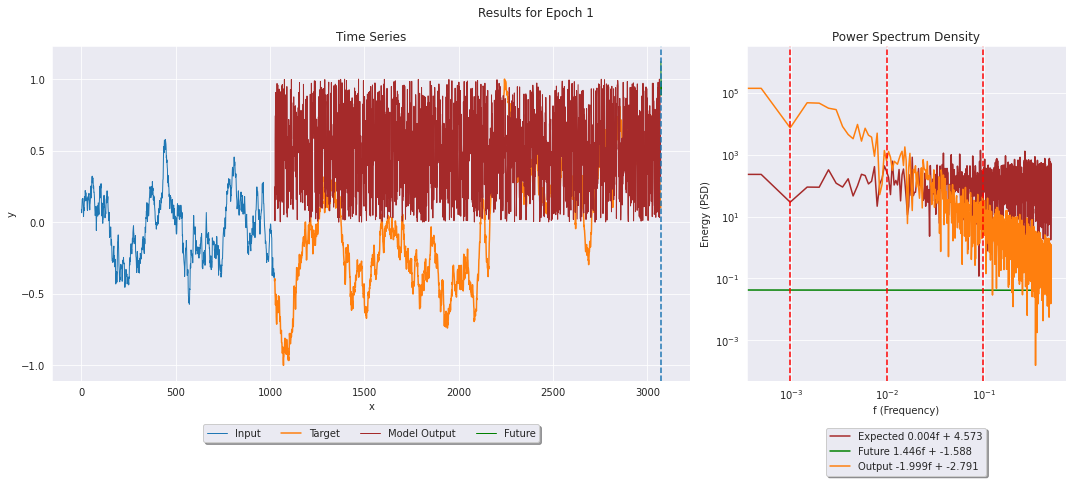

In [93]:
epoch=0
df = pd.read_pickle('MLP_ncut3_GNI.plk')
plot_results(x = df[~df.trainX.isnull()].trainX,
             y = df[~df.trainY.isnull()].trainY,
             z = df[~df[df.columns[epoch+2]].isnull()][df.columns[epoch+2]],
             w = df[~df[df.columns[epoch+3]].isnull()][df.columns[epoch+3]])


Refazendo o plot da função de treino, pois a do exemplo é muito ruim. Excluimos os 32 iniciais devido a arquitetura da rede, este é o tempo necessário para preencher a memória da primeira camada. 

In [ ]:
df = pd.read_pickle('MLP_ncut3_GNI.plk')

train = df.loss_train
valid = df.loss_valid

plot_loss(train,valid,title='Loss Metrics')

# Referencias 

[⚠️ Pytorch LSTMs for time-series data](https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7)

[Copyright 2019, Rafael Ballester-Ripoll Revision 8c81a1cb.](https://tntorch.readthedocs.io/en/latest/_modules/metrics.html)

https://blog.paperspace.com/pytorch-loss-functions/

[LSTM and LSTMCell ？ - PyTorch Forums](https://discuss.pytorch.org/t/lstm-and-lstmcell/7488/5)

[Optuna Reference](https://dl.acm.org/doi/10.1145/3292500.3330701)

[Has anyone implemented a optuna Hyperparameter optimization for a Pytorch LSTM?](https://stackoverflow.com/questions/72685216/has-anyone-implemented-a-optuna-hyperparameter-optimization-for-a-pytorch-lstm)

[10 Hyperparameters to keep an eye on for your LSTM model — and other tips](https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4)

[C 4.1 | 1D Convolution | CNN | Object Detection | Machine Learning | EvODN](https://www.youtube.com/watch?v=yd_j_zdLDWs)